# Utiliser la Data Science pour prédire l'issue de matchs de football :

L'objectif de ce projet va être de prédire les résultat de matchs de football de Ligue 1 à partir d'une base de données contenant tous les matchs effectués dans ce championnat depuis 2016.

Pour tester la qualité de notre prédiction, nous n'allons pas seulement regarder les indicateurs métriques classiques proposés par Skicit-Learn, mais allons tester nos resultats d'une manière plus concrète : notre dataset contient, entre autres, les côtes proposées par les sites de paris sportifs. Cela va pouvoir nous indiquer si nous prédisons mieux les matchs que les bookmakers, en regardant directement notre rentabilité (plus de détails en partie 2). 

Nous pourrons voir si nos résultats sont concrètement exploitables, lucrativement parlant.
Peut-on gagner de l'argent dans les paris sportifs grâce aux modèles statistiques de prédiction ?

## Partie 1 : Construction du modèle 

### A) Appropriation des données

Commençons par importer notre dataset : celui-ci est en réalité constitué de 4 data-sets intérmédiaires (correspondant aux resultats de championnat pour chaque année) que nous allons concaténer par la suite.

In [13]:
import pandas as pd
import numpy as np
import csv
data_ligue_1_2020 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2021/F1.csv") # Nous importons ce dataset mais ne l'utiliserons qu'en partie 2. 
# C'est celui sur lequel nous allons tester la rentabilité de notre modèle, donc il faut faire attention à ne pas biaiser nos prédictions en l'incluant dans les données d'apprentissage.
# On ne peut pas juste prendre les X_test classiques, car nos observations ne sont pas du tout indépendantes. Ainsi, pour s'assurer que nos estimateurs seront
#corrects, nous préférons prendre cette précaution.

data_ligue_1_2019 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1920/F1.csv")
data_ligue_1_2018 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1819/F1.csv")
data_ligue_1_2017 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1718/F1.csv")
data_ligue_1_2016 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1617/F1.csv")
df = pd.concat([data_ligue_1_2016, data_ligue_1_2017, data_ligue_1_2018, data_ligue_1_2019]) # On concatène les données des différentes années
df = df.set_index(np.arange(len(df))) # On établit un nouvel indice qui permettra d'éviter les doublons (auparavant, l'indice correspondait au numéro du match dans une année seulement)
display(df)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,F1,12/08/16,Bastia,Paris SG,0,1,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F1,12/08/16,Monaco,Guingamp,2,2,D,0.0,2.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F1,13/08/16,Bordeaux,St Etienne,3,2,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F1,13/08/16,Caen,Lorient,3,2,H,2.0,2.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F1,13/08/16,Dijon,Nantes,0,1,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,F1,07/03/2020,Nice,Monaco,2,1,H,0.0,1.0,A,...,2.38,0.25,2.06,1.87,2.07,1.85,2.09,1.90,2.01,1.84
1415,F1,07/03/2020,Reims,Brest,1,0,H,1.0,0.0,H,...,1.54,-0.50,2.01,1.92,2.02,1.89,2.05,1.93,1.99,1.86
1416,F1,08/03/2020,St Etienne,Bordeaux,1,1,D,0.0,0.0,D,...,1.61,-0.25,2.03,1.90,2.00,1.92,2.07,1.98,1.94,1.91
1417,F1,08/03/2020,Rennes,Montpellier,5,0,H,2.0,0.0,H,...,1.60,-0.25,1.97,1.96,1.97,1.95,2.00,2.00,1.94,1.91


On commence par remarquer qu'il y a beaucoup de colonnes : 126 pour être précis. Les 1419 lignes correspondent aux 1419 matchs joués entre août 2016 et mars 2020.

Cependant, dans ces 105 colonnes, le nombres de colonnes qui nous intéresse est finalement assez faible : les 5 premières nous donnent le contexte du match, et les données conçernent les paris sportifs dès la 24ème ligne (ce que nous n'allons pas utiliser dans un premier temps).

Précisons notre problématique : idéalement, nous voudrions utiliser nos résultats afin d'effectuer des paris sportifs. Ainsi, il faut absolument que nos données afin de prédire un match ne se basent que sur les informations dont nous disposons avant la réalisation de ce match. 

Nous allons donc devoir retravailler nos données afin que sur les lignes de chaque match, nous ayont à disposition toutes les informations ante match, et c'est à partir de ces variables que nous construirons un modèle de prédiction.

Nous devons donc choisir de manière arbitraire quelles sont les variables qui nous paraissent les plus intéréssantes afin de prédire l'issue d'un match. Commençons avec quatre variables : 
- le nombre de points de l'equipe à domicile AVANT de jouer le match
- le nombre de points de l'equipe à l'extérieur AVANT de jouer le match
- la forme de l'equipe à domicile AVANT de jouer le match
- la forme de l'equipe à domicile AVANT de jouer le match

Commençons par sélectionner les colonnes qui nous intéressent dans le dataset orignel afin de créer notre nouveau dataset.

In [834]:
df = df[['Date','HomeTeam', 'AwayTeam', 'FTR']]# FTR pour "Full-Time-Result"
display(df)

,Date,HomeTeam,AwayTeam,FTR
0,12/08/16,Bastia,Paris SG,A
1,12/08/16,Monaco,Guingamp,D
2,13/08/16,Bordeaux,St Etienne,H
3,13/08/16,Caen,Lorient,H
4,13/08/16,Dijon,Nantes,A
...,...,...,...,...
1414,07/03/2020,Nice,Monaco,H
1415,07/03/2020,Reims,Brest,H
1416,08/03/2020,St Etienne,Bordeaux,D
1417,08/03/2020,Rennes,Montpellier,H


Nous obtenons déjà quelque chose de plus épuré. On remarque que le résultat est exprimé avec une lettre : transformons nos données afin que le résultat de chaque match devienne une variable Y discrète, prenant la valeur 3 si l'équipe à domicile gagne, 1 si match nul et 0 si c'est l'équipe à l'extérieur qui l'emporte. Cela correspond aux points attribués à l'équipe à domicile à l'issue du match. Cela nous permettra d'utiliser des outils de classification sur Y.

In [835]:
df = df.rename(columns = {'FTR': 'Result'})

def Resultat(r):
  if r == 'H':
    return(3)
  elif r=='D':
    return(1)
  else :
    return(0)

df['Result'] = df['Result'].apply(Resultat)
display(df)

,Date,HomeTeam,AwayTeam,Result
0,12/08/16,Bastia,Paris SG,0
1,12/08/16,Monaco,Guingamp,1
2,13/08/16,Bordeaux,St Etienne,3
3,13/08/16,Caen,Lorient,3
4,13/08/16,Dijon,Nantes,0
...,...,...,...,...
1414,07/03/2020,Nice,Monaco,3
1415,07/03/2020,Reims,Brest,3
1416,08/03/2020,St Etienne,Bordeaux,1
1417,08/03/2020,Rennes,Montpellier,3


Nous pouvons alors déjà essayer de faire des statistiques descriptives sur notre DataFrame. Nous pouvons commencer à regarder la répartition de nos résultats, par exemple.

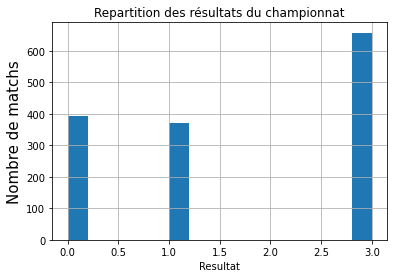

In [836]:
import matplotlib.pyplot as plt
%matplotlib inline

df['Result'].hist(bins=15)
plt.title('Repartition des résultats du championnat')
plt.xlabel("Resultat")
plt.ylabel('Nombre de matchs', size=15)
plt.show()


On remarque qu'une équipe gagne en moyenne la moitié de ses matchs à domicile, ce qui montre bien que jouer dans son propre stade, avec ses supporters, confère un avantage à une équipe (sinon au aurait plutôt du 33%). Il sera important de garder cette propriété en tête durant toute la suite du projet.

Le nombre de défaites et de nuls et quant à lui à peu près le même.


In [837]:
df.describe()

,Result
count,1419.000000
mean,1.649753
std,1.306630
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,3.000000


On retrouve bien nos 1419 observations : on remarque que la moyenne de points pris à domicile est de 1.69 points, avec un écart-type assez important. 


Passons maintenant à la création de nos nouvelles colonnes.
Celles- ci, sont rappelons-le : 

*   Le nombre de points de l'equipe à domicile AVANT de jouer le match
*   Le nombre de points de l'equipe à l'extérieur AVANT de jouer le match
*   La forme de l'equipe à domicile AVANT de jouer le match
*   La forme de l'equipe à domicile AVANT de jouer le match

Or, dans notre DataFrame, nous ne disposons que du résultat associé à chaque match. Nous allons donc devoir nous servir de l'historique des matchs et des résultats pour pouvoir recréer des colonnes qui dépendraient de tout ce qu'il s'est passé avant chaque match.

Commençons par le nombre de points des equipes : nous allons plutôt prendre le nombre de points **moyen** obtenu par chaque équipe : cela nous permettra de "normaliser" nos données afin que les coefficients puissent rester cohérents.
 
Nous voulions tout d'abord essayer de passer par des groupby, mais un problème se pose à nous : il faut à la fois compter les points d'une equipe quand celle-ci joue à domicile et quand celle-ci joue à l'éxterieur. 

Il faudrait donc créer un nouveau data frame en inversant HomeTeam et AwayTeam puis le mixer avec notre premier dataframe, pour enfin lui appliquer une dérivée de cusum qui consisterai en un cummean, fonction qui n'existe pas dans pandas.

 La tâche nous semble compliquée, même si en creusant plus en profondeur nous pourrions peut-être abouttir, en témoigne ce premier essai concluant.

In [841]:
display(df.groupby('HomeTeam')['Result'].cumsum())

0         0
1         1
2         3
3         3
4         0
       ... 
1414    141
1415     53
1416    120
1417    124
1418    126
Name: Result, Length: 1419, dtype: int64

Nous allons donc procéder à l'aide de boucles for, dans un soucis de simplicité. Commençons d'abord à créer les colonnes des nombres de points des deux equipes avant le match.

In [842]:
df['PtsHomeTeam'] = np.zeros(len(df)) # Création des nouvelles colonnes que nous allons remplir avec des boucles
df['PtsAwayTeam'] = np.zeros(len(df))

for team in df.drop_duplicates(['HomeTeam'])['HomeTeam']: # Nous procédons équipe par équipe
  
  average_pts_team = 1.39 # On initilise à 1.39, qui est le nombre moyen de points pris par match en moyenne dans tout le championnat. 
  # En effet, en commençant, on ne sait rien sur aucun équipe, à part que celle-ci joue en Ligue 1 et a donc en moyenne pris 1.39 point en moyenne lors de ses derniers matchs.
  # (C'est différent de notre 1.65 obtenu avec describe(), qui correspond au nombre moyen de points pris à domicile.)

  nb_matches = 1 # On considère que ce 1.39 correspond à un match "genèse". On fixe donc le compteur à 1.

  for k in range(len(df)): # Pour chaque équipe, on parcourt le dataframe pour compter ses points. Le nombre d'equipes étant faible, nous pouvons nous le permettre sans que cela prenne un temps d'exécution trop long.

    if df['HomeTeam'].iloc[k] == team : 
      
      df['PtsHomeTeam'].iloc[k] = average_pts_team # on remplit la colonne du dataframe correpondante
       
      r = df['Result'].iloc[k] # on extrait le résultat afin de préparer le prochain remplissage de colonne

      average_pts_team = (average_pts_team*nb_matches + r)/(nb_matches+1) # à l'aide du résultat, on obtient le prochain nombre de points moyen qui viendra
      
      nb_matches = nb_matches+1
    
    if df['AwayTeam'].iloc[k] == team : # Pour chaque equipe on doit tester la colonne domicile ET la colonne extérieur pour bien compter tous les points au fur et à mesure.
      
      df['PtsAwayTeam'].iloc[k] = average_pts_team

      r = df['Result'].iloc[k]

      pts = (1/2)*r**2 - (5/2)*r + 3 # Attention, il faut bien appliquer une fonction à r car ici on compte les points de l'equipe à l'extérieur. Cette fonction est la fonction la plus simple vérifiant f(3)=0, f(1)=1, f(0)=3.
      
      average_pts_team = (average_pts_team*nb_matches + pts)/(nb_matches+1) 
      
      nb_matches = nb_matches+1

    if nb_matches >= 39 : 
      nb_matches = 1 

      # Les deux dernières lignes servent à réinitialiser le nombre de points obtenus. En effet, à la fin de chaque championnat, une équipe change beaucoup avec le marché des transferts.
      # Chaque equipe joue 38 matchs en une anné de championnat (sauf en 2019 à cause du covid où le championnat s'est arrêté prématurément, mais ça n'a pas d'impact ici)
      # Au bout de 38 matchs, on réinitalise le compteur. Ici, il faut que nb_matches >= 39 comme on a commencé à 1.

      # Cependant, le compteur n'est pas totalement réinitailisé à proprement parler. En effet, si on voulait faire totalement table rase du passé,
      # On entrerait n = 0 en initialisation et à la fin du programme. Ici, ce n = 1 permet de garder un lien d'une saison à l'autre : tout ce qu'il s'est passé
      # en 2018 se matérialisera sous la forme d'un match supplémentaire en 2019 dans le comptage de la moyenne par match. Il permet de faire le lien d'une saison à l'autre.
      
      # Pourquoi fait-on cela ? Une saison de championnat n'est pas totalement indépendante de la précédente, et donc symboliser le championnat de 2018 sous la forme d'un match 0 de la saison 2019
      # permet de rendre compte de cette continuité entre les saisons : les équipes ne sont pas totalement renouvelées d'une saison à l'autre, les entraineurs, le budget, le fonctionnement du club
      # restent les mêmes. 

      # Au final, cela permettra à notre modèle d'avoir des données plus réalistes. Repartir de 0 à chaque nouvelle saison rendrait notre modèle final moins précis.
      # Cependant, nous avons ici choisi de pondérer l'année passée à un seul match, ce qui finalement a un effet assez faible sur nos resultats.
    
display(df)

# Les données que nous obtenons diffèrent donc légèrement des indicateurs utilisés sur Internet.
# Nous avons tout de même bien vérifié que ce programme fonctionne en reproduisant certains calculs "à la main".

,Date,HomeTeam,AwayTeam,Result,PtsHomeTeam,PtsAwayTeam,FormHomeTeam,FormAwayTeam
0,12/08/16,Bastia,Paris SG,0,1.390000,1.390000,1.39,1.39
1,12/08/16,Monaco,Guingamp,1,1.390000,1.390000,1.39,1.39
2,13/08/16,Bordeaux,St Etienne,3,1.390000,1.390000,1.39,1.39
3,13/08/16,Caen,Lorient,3,1.390000,1.390000,1.39,1.39
4,13/08/16,Dijon,Nantes,0,1.390000,1.390000,1.39,1.39
...,...,...,...,...,...,...,...,...
1414,07/03/2020,Nice,Monaco,3,1.409741,1.463475,1.20,2.20
1415,07/03/2020,Reims,Brest,3,1.408782,1.263929,1.20,1.20
1416,08/03/2020,St Etienne,Bordeaux,1,1.097476,1.324588,0.20,1.20
1417,08/03/2020,Rennes,Montpellier,3,1.727583,1.483823,1.40,1.40


On remarque qu'au début des colonnes, nous obtenons des 1,39 pour tout le monde : c'est ce à quoi on s'attendait au vu de notre initialisation. On remarque que les valeurs varient entre 1.8 et 1 à la fin du championnat : c'est plutôt normal aussi comme il est très rare qu'une équipe gagne ou perde tous ses matchs sur toute la durée d'un championnat, comme il s'agit d'une moyenne, la variance est plus faible. 

Maintenant, essayons d'implémenter des colonnes qui renvoient les états de forme des deux équipes. En effet, la moyenne des points obtenus par match sur une saison est finalement une donnée assez faible. Il peut arriver que l'equipe sois en manque de confiance, que l'entraîneur d'une équipe change, que la tactique change...et ces faits qui jouent sur le court-terme peuvent en partie être renvoyés par cet indicateur de forme des équipes. 

Ici, nous allons considérer que la forme d'une équipe correspond aux points moyens obtenus par match uniquement sur ses 5 derniers matchs. (5 étant un nombre abritraire, mais généralement celui choisi pour toutes les analyses dans le milieu).

Pour implémenter ces colonnes, encore plus complexes que les précédentes, il nous semble inévitable de repasser par des boucles for.

In [843]:
df['FormHomeTeam'] = np.zeros(len(df))

df['FormAwayTeam'] = np.zeros(len(df)) # Comme la dernière fois, on commence par créer des colonnes vierges pour accueillir nos données.

for team in df.drop_duplicates(['HomeTeam'])['HomeTeam']: # Une fois de plus on procède équipe par équipe.

  last_results = 1.39*np.ones(5) # Pour chaque équipe, on créée un vecteur qui retrace ses 5 derniers resultats.
  # Comme la dernière fois, on initilise à 1,39, qui est le nombre moyen de points pris par match en moyenne dans tout le championnat.

  for k in range(len(df)): # Comme la dernière fois, on parcourt tout le data frame à la recherche de matchs qui concernent notre équipe.

    if df['HomeTeam'].iloc[k] == team :

      form = np.mean(last_results) # La forme de chaque equipe correspond alors à la moyenne de notre vecteur last_results.

      df['FormHomeTeam'].iloc[k] = form

      r = df['Result'].iloc[k]

      last_results = np.delete(np.insert(last_results, [0], r) ,[5]) # On commence par insérer notre résultat le plus actuel en première position de notre vecteur, 
      # puis on supprime la dernière valeur, qui est alors le résultat du N-6 ème match joué.
    
    if df['AwayTeam'].iloc[k] == team :
      
      form = np.mean(last_results)

      df['FormAwayTeam'].iloc[k] = form

      r = df['Result'].iloc[k]

      pts = (1/2)*r**2 - (5/2)*r + 3
  
      last_results = np.delete(np.insert(last_results, [0], pts) ,[5])

# Ici, on décide de ne pas réinitialiser le compteur entre chaque saison. Ainsi, nous pouvons garder une trace de la continuité entre deux saisons de championnat. 
# Comme nous l'avons dit précément, une saison de championnat n'est pas totalement indépendante de la précédente, et notre indicateur de forme permet de capter une plus grande partie de cet effet que précément.

display(df)



,Date,HomeTeam,AwayTeam,Result,PtsHomeTeam,PtsAwayTeam,FormHomeTeam,FormAwayTeam
0,12/08/16,Bastia,Paris SG,0,1.390000,1.390000,1.39,1.39
1,12/08/16,Monaco,Guingamp,1,1.390000,1.390000,1.39,1.39
2,13/08/16,Bordeaux,St Etienne,3,1.390000,1.390000,1.39,1.39
3,13/08/16,Caen,Lorient,3,1.390000,1.390000,1.39,1.39
4,13/08/16,Dijon,Nantes,0,1.390000,1.390000,1.39,1.39
...,...,...,...,...,...,...,...,...
1414,07/03/2020,Nice,Monaco,3,1.409741,1.463475,1.20,2.20
1415,07/03/2020,Reims,Brest,3,1.408782,1.263929,1.20,1.20
1416,08/03/2020,St Etienne,Bordeaux,1,1.097476,1.324588,0.20,1.20
1417,08/03/2020,Rennes,Montpellier,3,1.727583,1.483823,1.40,1.40


On remarque alors que la forme semble bien être un indicateur assez différent du nombre de points, bien que corrélé. Par exemple, à la fin du championnat de 2019, on voit que Saint-Etienne réalisait une assez mauvaise performance (seulement 1,097 point de pris par match en moyenne) mais était dans une forme encore plus catastrophique ! (1 point seuleument gagné sur ses 5 derniers matchs).
On voit aussi que Lille et Rennes sont au coude à coude en nombre de points dans le championnat, mais Lille étant beaucoup plus en forme, peut-être qu'ils auraient devancé Rennes si le championnat n'avait pas été interrompu.

Nous pouvons alors supprimer nos lignes d'initialisation, qui ne reflètent pas forcément des informations intéréssantes (ici, une absence d'information). Bien que cela a été utile pour construire nos colonnes, baser notre modèle sur celles-ci pourrait entraîner des biais.


In [844]:
df = df.drop(index = np.arange(10))
df = df.set_index(np.arange(len(df)))
display(df)

,Date,HomeTeam,AwayTeam,Result,PtsHomeTeam,PtsAwayTeam,FormHomeTeam,FormAwayTeam
0,19/08/16,Lyon,Caen,3,2.195000,2.195000,1.712,1.712
1,20/08/16,Angers,Nice,0,0.695000,2.195000,1.112,1.712
2,20/08/16,Lille,Dijon,3,0.695000,0.695000,1.112,1.112
3,20/08/16,Lorient,Bastia,0,0.695000,0.695000,1.112,1.112
4,20/08/16,Nantes,Monaco,0,2.195000,1.195000,1.712,1.312
...,...,...,...,...,...,...,...,...
1404,07/03/2020,Nice,Monaco,3,1.409741,1.463475,1.200,2.200
1405,07/03/2020,Reims,Brest,3,1.408782,1.263929,1.200,1.200
1406,08/03/2020,St Etienne,Bordeaux,1,1.097476,1.324588,0.200,1.200
1407,08/03/2020,Rennes,Montpellier,3,1.727583,1.483823,1.400,1.400


In [845]:
df.describe()

,Result,PtsHomeTeam,PtsAwayTeam,FormHomeTeam,FormAwayTeam
count,1409.000000,1409.000000,1409.000000,1409.00000,1409.000000
mean,1.649397,1.366806,1.394589,1.34464,1.401151
std,1.306344,0.482027,0.485403,0.66118,0.652948
min,0.000000,0.180800,0.176988,0.00000,0.000000
25%,0.000000,1.043397,1.068667,0.80000,0.878000
50%,1.000000,1.303361,1.333562,1.31200,1.400000
75%,3.000000,1.586875,1.622869,1.80000,1.800000
max,3.000000,2.960195,2.962849,3.00000,3.000000


Ces statistiques descriptives nous permettent de tester la cohérence de nos résultats, pour voir si on a bien construit nos colonnes. On observe qu'en moyenne le nombre de points par match moyen des equipes et leur forme moyenne sont presque identiques : on pouvait s'y attendre, étant donné que les effets de forme se compensent quand on considère leur moyenne. 

Cela dit, l'écart-type de la forme est plus important, ce à quoi on s'attendait (plus de variations de forme que de variations de points moyens sur toute la saison).

Il peut sembler étrange que la moyenne de points des équipes qui jouent à l'extérieur soit plus élevée que la moyenne de points des équipes qui jouent à domicile. Cela peut s'expliquer par le fait que quand on équipe joue à domicile, elle a probablement joué un match de plus à l'extérieur avant (une fois sur deux) qu'elle perd plus souvent comme on l'a vu dans le describe(). 
A l'inverse, une equipe qui joue à l'extérieur a probablement joué à domicile avant et aborde donc le match avec plus de points en moyenne (même si on le voit, l'effet est assez infime). Cet effet est donc logiquement exacerbé sur les formes, plus variables.

On peut aussi être surpris par le fait que les moyennes de points des équipes sont inférieures à la moyenne des résultats. Une fois de plus, c'est normal : la colonne Result représente un résultat à domicile, or nous avons remarqué que les equipes gagnaient plus souvent leurs matchs à domicile. Les indicateurs "PtsHomeTeam" et "PtsAwayTeam" représentent eux les points moyens obtenu en jouant à domicile ET à l'éxterieur. Il ne faut pas les confondre avec les nombre de points qu'une équipe obtient en jouant à domicile. Il est vrai que le nom de cette variable peut prêter à confusion, mais il faut bien garder en tête que ce n'est pas la même chose. 
On s'attends donc bien à ce que la moyenne du résultat, qui nos correpond qu'à des matchs joués à domicile, soit plus élevée que les moyennes de PtsHomeTeam et PtsAwayTeam qui correspondent, une fois de plus, à des matchs joués à domicile ET à l'extérieur. Cela corrobore même notre observation qui disait que on a plus de chance de gagner quand on joue à domicile.

Nos resultats sont donc bien cohérents.





### B) Visualisation

Avec ces données beaucoup plus riches, nous allons pouvoir essayer de voir graphiquement les effets de nos variables sur le résultat d'un match.

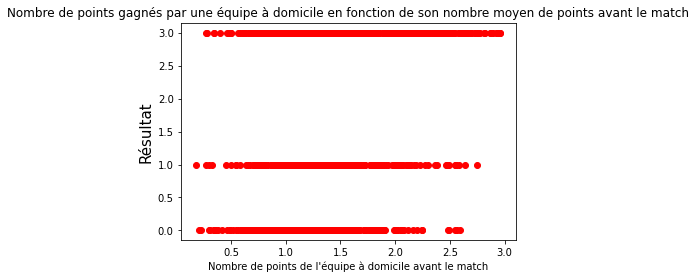

In [846]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df['PtsHomeTeam'],df['Result'],'ro')
plt.title('Nombre de points gagnés par une équipe à domicile en fonction de son nombre moyen de points avant le match')
plt.xlabel("Nombre de points de l'équipe à domicile avant le match")
plt.ylabel('Résultat', size=15)
plt.show()



Il est assez difficile de distinguer grand chose sur ce graphique, car comme notre Y ne prend que 3 valeurs, celles-ci se supperposent sur le graphique. Il semble tout de même y avoir une correlation entre le nombre de points moyen obtenu par une équipe à domicile avant le match et le résultat du match : on voit que le trait rouge se décale vers la droite en montant, ce qui veut dire que si une equipe à domicile gagne, elle a plus régulièrement des points moyens par match élevés.
Essayons de vérifier cela avec des graphiques plus détaillés :


Text(0.5, 1.0, "Répartition des points de équipes à l'extérieur avant le match selon le résultat final du match")

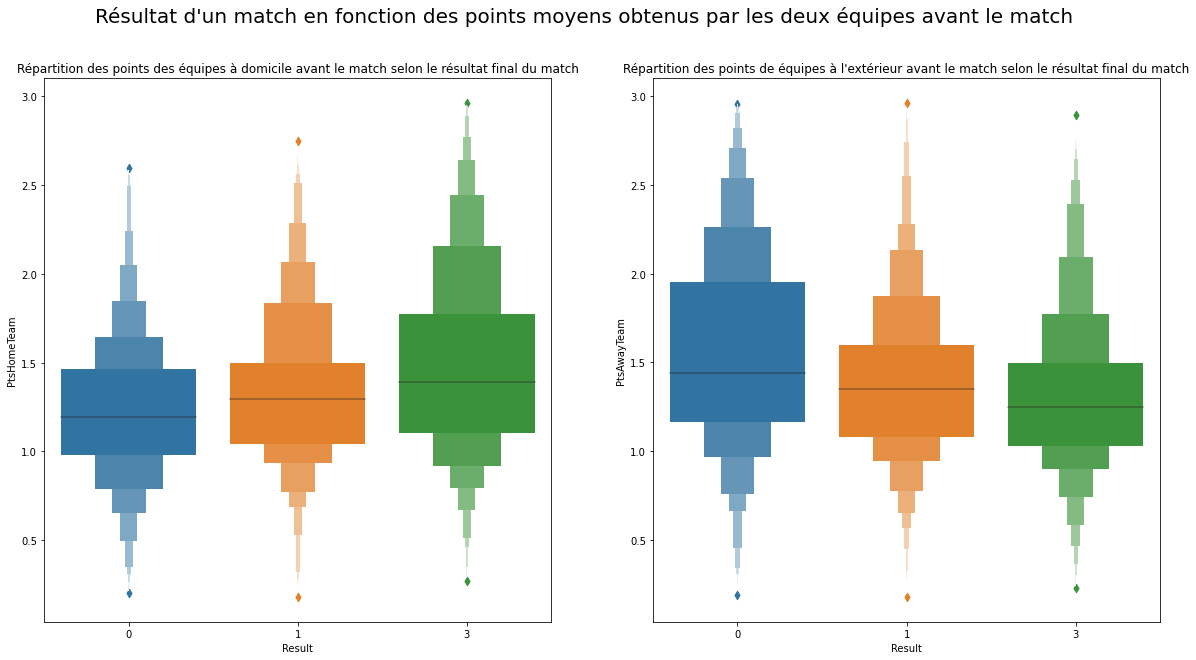

In [847]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Résultat d'un match en fonction des points moyens obtenus par les deux équipes avant le match", fontsize = 20)

sns.boxenplot(ax=axes[0], x='Result',y='PtsHomeTeam', data=df)
axes[0].set_title("Répartition des points des équipes à domicile avant le match selon le résultat final du match")
sns.boxenplot(ax=axes[1], x='Result',y='PtsAwayTeam', data=df)
axes[1].set_title("Répartition des points de équipes à l'extérieur avant le match selon le résultat final du match")

La corrélation entre le nombre de points des équipes ressort plus clairement ici : on voit que plus le résultat est grand, plus les points moyens de l'équipe à domicile avant le match étaient élevés, en moyenne. A l'inverse, plus les résultat est élevé, plus les points moyens de l'équipe à l'extérieur avant le match étaient faibles, en moyenne. On garde à l'esprit que le résultat correspond aux points obtenus par l'equipe à domicile à l'issue du match. Ainsi, ce graphique nous montre simplement que plus une équipe a obtenu de points avant le match, plus elle a de chances de gagner.

Pour s'en convaincre, utilisons l'argument lm de seaborn : (qui focntionne aussi pour les classifications, selon la documentation).

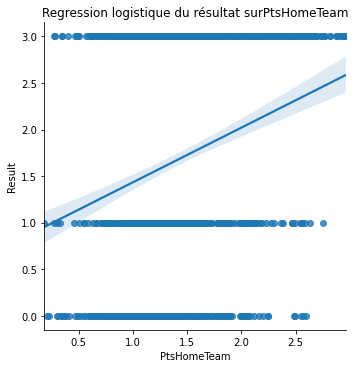

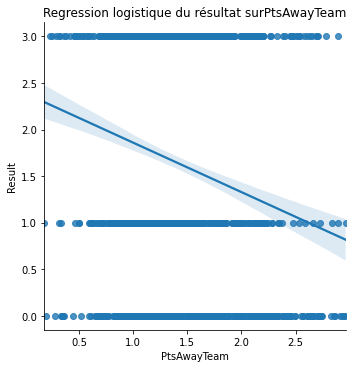

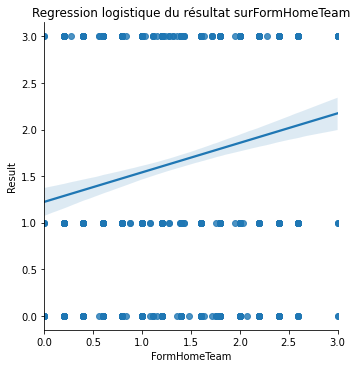

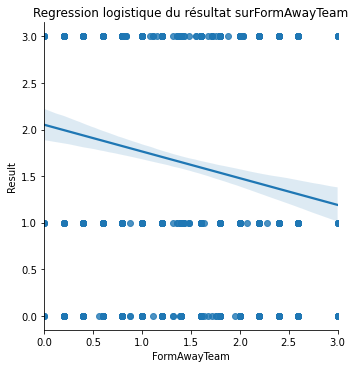

In [848]:
import seaborn as sns
for k in ["PtsHomeTeam", "PtsAwayTeam", "FormHomeTeam", "FormAwayTeam"]:
  sns.lmplot(data=df, x=k, y="Result")
  plt.title('Regression logistique du résultat sur'+ k)


On peut désormais identifier les correlations auxquelles on s'attendait : on voit bien que plus une équipe à domicile est en forme ou a gagné de points durant le championnat, plus elle a de chances de gagner son prochain match. A l'inverse, plus l'equipe à l'éxterieur est en forme ou a gagné de points, plus il y a de chance pour que l'equipe à domicile perde. Nos indicateurs sont donc bien corrélés à notre résultat et peuvent donc servir à le prédire. 
Comment effectuer ces prédictions et à quel point seront-elles exactes ?
C'est ce que nous allons découvrir en partie C.

Avant cela, continuons d'essayer de représenter visuellement de notre DataSet afin de s'en imprégner et mieux appréhender les données : celui-ci est devenu très riche, en témoigne les grapes suivant, qui se focalisent sur les données propres à chaque équipe qui a joué dans le championnat :

'Indication : les lignes du haut et du bas représentent les mêmes données, sous une forme différente'

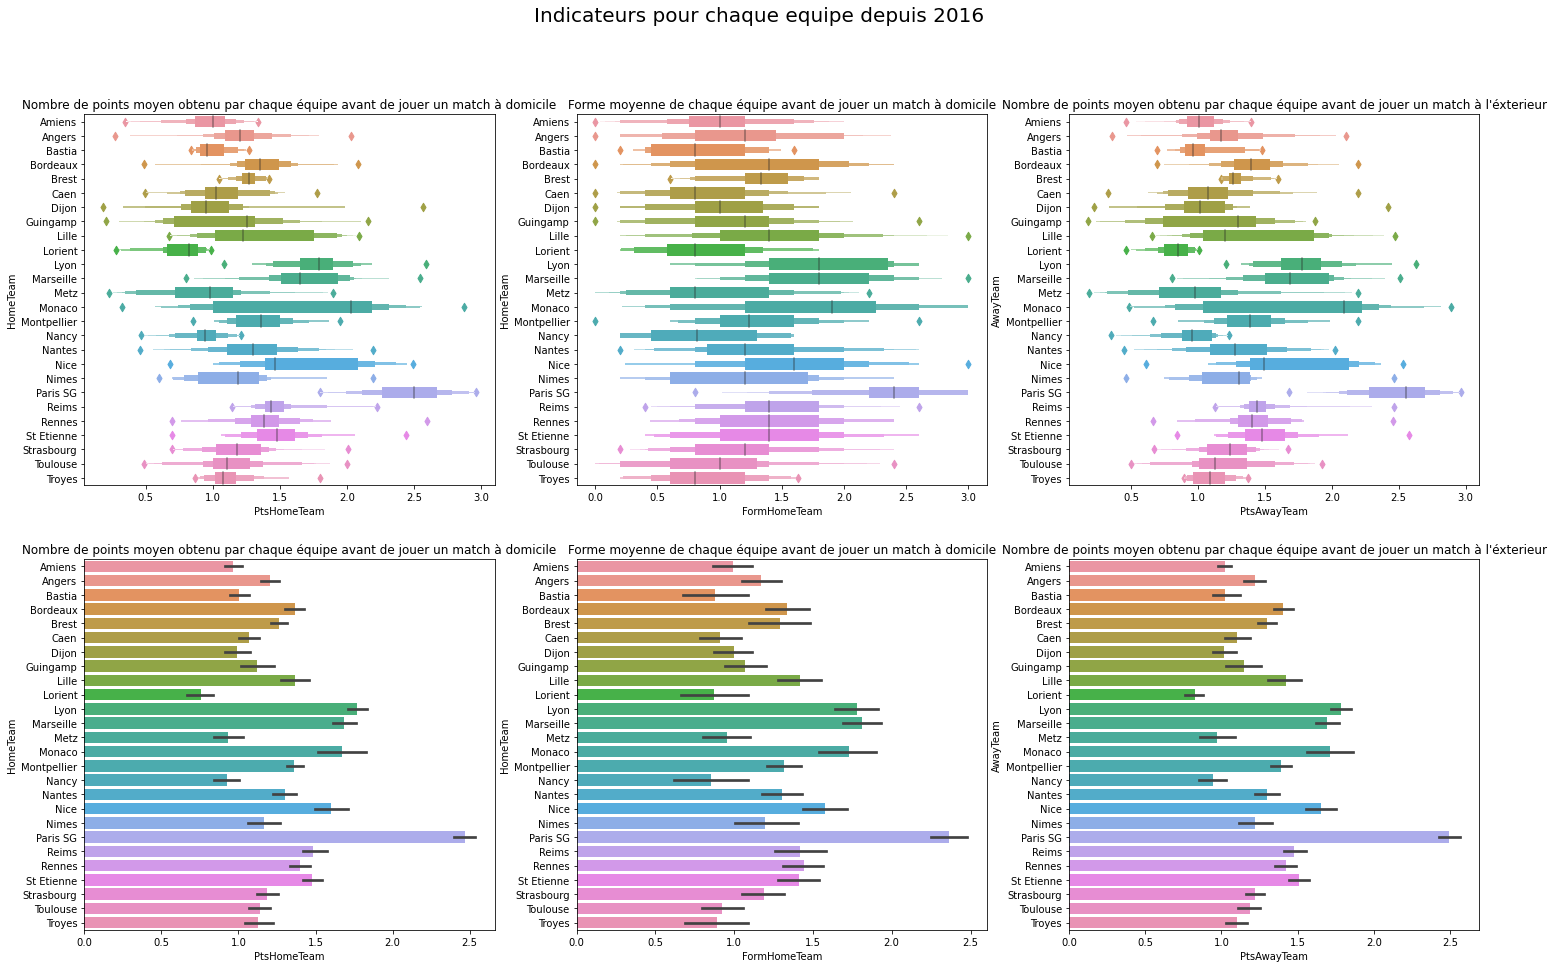

In [849]:
fig, axes = plt.subplots(2, 3, figsize=(25, 15))
fig.suptitle('Indicateurs pour chaque equipe depuis 2016', fontsize = 20)


sns.boxenplot(ax=axes[0,0],x='PtsHomeTeam',y='HomeTeam', data=df.sort_values('HomeTeam'))
axes[0,0].set_title('Nombre de points moyen obtenu par chaque équipe avant de jouer un match à domicile')

sns.boxenplot(ax=axes[0,1], x='FormHomeTeam',y='HomeTeam', data=df.sort_values('HomeTeam'))
axes[0,1].set_title('Forme moyenne de chaque équipe avant de jouer un match à domicile')

sns.boxenplot(ax=axes[0,2],x='PtsAwayTeam',y='AwayTeam', data=df.sort_values('AwayTeam'))
axes[0,2].set_title("Nombre de points moyen obtenu par chaque équipe avant de jouer un match à l'éxterieur")

sns.barplot(ax=axes[1,0],x='PtsHomeTeam',y='HomeTeam', data=df.sort_values('HomeTeam'))
axes[1,0].set_title('Nombre de points moyen obtenu par chaque équipe avant de jouer un match à domicile')

sns.barplot(ax=axes[1,1], x='FormHomeTeam',y='HomeTeam', data=df.sort_values('HomeTeam'))
axes[1,1].set_title('Forme moyenne de chaque équipe avant de jouer un match à domicile')

sns.barplot(ax=axes[1,2],x='PtsAwayTeam',y='AwayTeam', data=df.sort_values('AwayTeam'))
axes[1,2].set_title("Nombre de points moyen obtenu par chaque équipe avant de jouer un match à l'éxterieur")
'Indication : les lignes du haut et du bas représentent les mêmes données, sous une forme différente'






Les box permettent de communiquer beaucoup d'informations : plus la box de chaque equipe est large, plus celle-ci est inconstante : on voit ainsi que Monaco dont le nombre moyen de points dans le championnat a beaucoup varié depuis 2016 (cf le premier graphique). Cela se vérifie empiriquement : 1 ère du championnat en 2017, 18 ème en 2018. Le fait que la largeur des boîtes reflètent l'inconstance est encore plus mise en lumière par les graphiques de la deuxième colonne : on voit que les box sont encore plus larges, car l'indicateur de forme est par définition plus variable que l'indicateur de points moyens. 

Nous pouvons aussi effectuer un classement des équipes sur toute cette période, ou en tous cas voir se dégager des grandes tendances : plus la médiane de points ou de forme d'une équipe (qui correspond au trait noir sur la box) est à droite, plus cette équipe a obtenu de bons résultats durant le championnat. C'est donc sans surprise que l'on voit la box de Paris pointer beaucoup plus à droite de toutes les autres. Monaco sort aussi du lot mais est plus inconstant, viennent ensuite Lyon puis Marseille, clairement un cran en dessous de Paris, et un peu en dessous Monaco mais plus constantes.

Essayons désormais de voir si nous allons pouvoir facilement classifier nos données :

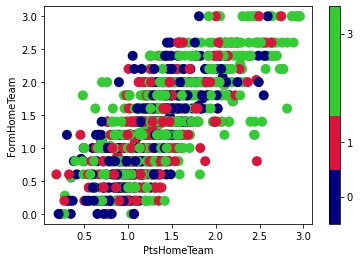

In [850]:
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen","limegreen"])
norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)
fig, ax = plt.subplots()
df.plot.scatter(x="PtsHomeTeam", y="FormHomeTeam", c="Result", ax=ax, 
                cmap=cmap, norm=norm, s=100, edgecolor ='none', colorbar=False)
fig.colorbar(ax.collections[0], ticks=[0,1,3])

plt.show()
                                 


On remarque que la classification va être difficile à réaliser : les nuages de points se superposent ce qui montre que nos indicateurs ne sont pas si discriminants pour prédire les résultats. En effet, ici les points verts correspondent aux victoires à domicile, les points rouges aux égalités et les points bleus aux défaites. On remarque tout de même que le nuage de points vert est un peu plus à droite que les rouge et bleu, ce qui montre que les points moyens d'une équipe avant le match jouent tout de même un peu sur le résultat. Au niveau de la forme, cela semble encore plus compliqué à distinguer : on peut quand même le voir en remarquant que tout en bas, on retrouve surtout des points bleus, tandis qu'en haut, on retrouve plus de points verts.

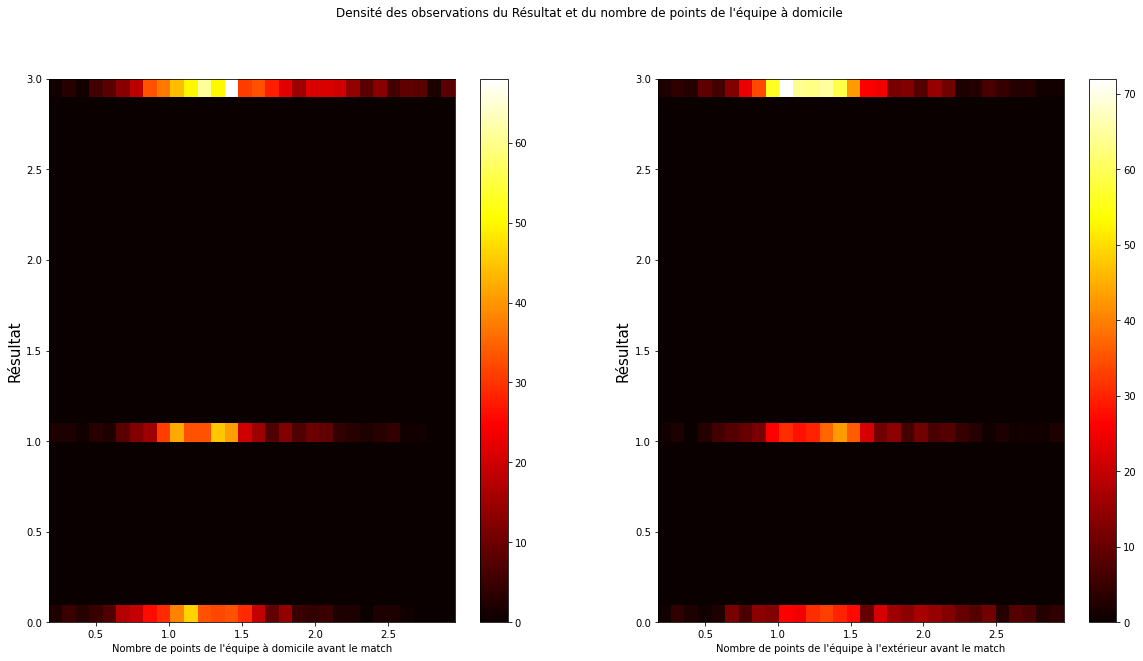

In [851]:
figure = plt.figure(figsize = (20, 10))
plt.subplot(121)
plt.hist2d(data=df, x='PtsHomeTeam', y='Result', cmap='hot', bins=30)
plt.suptitle("Densité des observations du Résultat et du nombre de points de l'équipe à domicile")
plt.xlabel("Nombre de points de l'équipe à domicile avant le match")
plt.ylabel('Résultat', size=15)
plt.colorbar()
plt.subplot(122)
plt.hist2d(data=df, x='PtsAwayTeam', y='Result', cmap='hot', bins=30)
plt.suptitle("Densité des observations du Résultat et du nombre de points de l'équipe à domicile")
plt.xlabel("Nombre de points de l'équipe à l'extérieur avant le match")
plt.ylabel('Résultat', size=15)
plt.colorbar()

Ce dernier graphique est une version plus détaillée du premier de cette partie : on peut désormais observer la densité de répartition de nos couples (Résultat,PtsHomeTeam) et (Résultat,PtsAwayTeam). Ce dernier On observe ici clairement deux phénomènes : les indicateurs de points moyens varient généralement entre 1 et 1.5 points, car comme il s'agit d'une moyenne, leur variance est relativement faible. On remarque aussi une fois de plus le phénomène principal de nos données : une équipe gagne plus souvent quand elle joue à domicile (on observe plus de Résultats égaux à 3).

### C) Modélisation

Nous allons désormais pouvoir passer à la construction de notre modèle ! 

Il s'agit ici clairement d'un problème de classification , Y étant discret (il ne prend comme valeurs que 3, 1 et 0). On va donc pouvoir utiliser le module de regression logistique de sklearn.

Commençons par séparer nos datasets en train et test.

In [852]:
from sklearn.model_selection import train_test_split

X = df[['PtsHomeTeam', 'PtsAwayTeam', 'FormHomeTeam', 'FormAwayTeam']]
Y = df['Result']

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=7)

print(X_train.shape, X_test.shape)

(986, 4) (423, 4)


Notre dataset qui va servir à entraîner le régresseur correpond à 70% de nos observations, soit 993 observation. Nous testerons ensuite notre modèle sur 30% des données, soit notre X_test constitué de 426 données.

Maintenant, nous pouvons entraîner notre régresseur sur X_train:

In [853]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, Y_train)

LogisticRegression()

Commençons par vérifier si notre modèle marche sur les premières données de X_test. Regardons ce qu'il prédit pour les 5 premiers matchs de X_test.

In [854]:
display(X_test.head().index, lr.predict(X_test[:5]))

Int64Index([1083, 313, 734, 284, 671], dtype='int64')

array([3, 3, 3, 0, 0])

In [855]:
# Ce qui correspond aux matchs :
display(df.iloc[1083], df.iloc[313], df.iloc[734], df.iloc[284], df.iloc[671])

Date            28/04/2019
HomeTeam              Caen
AwayTeam             Dijon
Result                   3
PtsHomeTeam       0.794106
PtsAwayTeam       0.860471
FormHomeTeam           1.2
FormAwayTeam           1.4
Name: 1083, dtype: object

Date            15/04/17
HomeTeam            Nice
AwayTeam           Nancy
Result                 3
PtsHomeTeam      2.16333
PtsAwayTeam     0.981515
FormHomeTeam         2.2
FormAwayTeam         0.6
Name: 313, dtype: object

Date            12/05/18
HomeTeam           Lille
AwayTeam           Dijon
Result                 3
PtsHomeTeam     0.978787
PtsAwayTeam      1.24282
FormHomeTeam         1.4
FormAwayTeam         1.4
Name: 734, dtype: object

Date            18/03/17
HomeTeam          Nantes
AwayTeam            Nice
Result                 1
PtsHomeTeam      1.27967
PtsAwayTeam      2.14633
FormHomeTeam         1.6
FormAwayTeam         2.2
Name: 284, dtype: object

Date             31/03/18
HomeTeam            Dijon
AwayTeam        Marseille
Result                  0
PtsHomeTeam       1.25756
PtsAwayTeam       1.95566
FormHomeTeam          1.4
FormAwayTeam          1.4
Name: 671, dtype: object

Les résultats sont intéréssants : on voit qu'on prédit bien l'issue de quatre matchs sur cinq. Le seul match que nous prédisons mal est un match nul, résultat assez diffciles à prédire car très incertains. Le match Lille Dijon pouvait d'ailleurs paraître assez incertain, les données brutes laissent même présager un certain avantage de Dijon, pourtant notre modèle ne s'est pas trompé et a bien prédit la victoire de Lille. C'est prometteur.

De plus, il ne semble pas se dégager d'apétence de notre algorithme à miser sur la victoire de l'equipe à domicile. En effet, nous avons vu que c'est généralement l'équipe à domicile qui gagne, donc pourquoi se mouiller ? Il faut que nous fassions attention à ce que l'algorithme ne renvoie pas 3 trop souvent, comme c'est le résultat le plus probable. Mais ici, nous prédisons tout de même deux victoires à l'extérieur, ce qui laisse présager que notre modèle s'adapte bien à chaque situation.

Pour pouvoir tester si notre modèle est vraiment bon, nous allons utiliser les metriques d'évaluation proposées par sklearn.



In [856]:
from sklearn.metrics import classification_report

Y_pred = lr.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.49      0.43      0.46       111
           1       0.00      0.00      0.00       125
           3       0.49      0.86      0.63       187

    accuracy                           0.49       423
   macro avg       0.33      0.43      0.36       423
weighted avg       0.35      0.49      0.40       423



Nous remarquons tout de suite que nous prédisons très mal les matchs nuls : sur les 125, nous n'en avons bien prédit aucun...Nous sommes donc très mauvais pour prédire les matchs nuls. Cependant, pour les victoires et les défaites, les résultats sont encourageants. 

Ce qu'il est important de regarder, dans le cadre d'un pari, c'est surtout la precision, c'est à dire la pertinence de l'information remontée.

En effet, le recall nous indique ici que 86% des victoires à domicile ont bien été prédites par notre modèle. Cela ne nous intéresse que peu, dans le sens ou l'objectif d'un pari n'est pas de deviner tous les matchs, mais plutôt de ne pas se tromper sur ceux qu'on essaye de prédire.

Ici, nous avons une donnée très intéréssante : notre précision pour prédire les victoires des équipes à l'extérieur semble assez élevée. En effet, la proportion de victoires à l'extérieur ne correspond qu'à environ 1/4 ou au plus 1/3 des matchs, or 49% de nos paris "l'equipe à l'extérieur gagne" s'avèrent juste. Nous sommes donc bien meilleurs qu'en pariant juste au hasard. On pourrait donc essayer d'adopter une stratégie de paris ne consistant à parier que sur les victoires à l'extérieur, quand c'est le résultat prédit par notre algorithme.

Maintenant, nous allons pouvoir essayer d'exploiter ses résultats lucrativement parlant : est-il possible de gagner de l'argent grâce aux prédictions de notre modèle ?

## **PARTIE 2 : MACHINE LEARNING VS BOOKMAKERS**





Dans cette partie, nous allons confronter nos résultats à la réalité. En effet, il sera toujours impossible de prédire à la perfection des matchs de football, étant donné que c'est un sport rempli d'incertitudes où l'aléatoire joue beaucoup. 
Ainsi, il est sera toujours impossible d'obtenir des métriques d'évaluation très satisfaisantes, surtout au vu du peu de données dont l'on dispose avant chaque match. C'est notament ce qui justifie l'existence des paris sportifs : c'est justement parce qu'il y a une part inimputable de chance que des bookmakers (les personnes qui proposent les paris), parviennent à s'enrichir.

Ainsi, si nous prenons les bookmakers pour référence, on peut considérer que nos résultats seraient bons à partir du moment où ils parviendrait à mieux estimer que les bookmakers la loi de probabilité de nos résultats Y, sachant X, les données d'avant chaque match. Notre régression logistique est une tentative d'estimer cette loi, et nous allons pouvoir voir si nos résultats nous permettent de gagner de l'argent, sur le moyen terme.


### **A) Qu'est ce qu'une côte ?**

Tout d'abord, afin de bien expliciter notre objectif et notre manière de faire, nous allons revenir à la base des paris sportifs. Dans cette partie, nous allons réexpliquer ce qu'est une côte et le fonctionnement des paris sportifs.

Une cote représente le gain potentiel que le parieur peut recevoir en misant 1 euro si son pari est gagnant. C’est le site de pari sportif qui la détermine. Il faut savoir qu’une cote est nombre décimal (1.82 ou 2.13 par exemple) qui ne peut être inférieur à 1.

Voici un petit programme qui détaille le calcul de nos bénéfices :



In [857]:
def benefices_pari(mise, cote, resultat_predit, resultat_reel) : 

  if resultat_predit == resultat_reel :
     return(mise*cote-mise) # On empoche nos gains potentiels c'est à dire notre mise fois la côte, moins notre investissement initial, c'est à dire la mise
    
  else :
    return(-mise) 

print("Voici un exemple pour mieux comprendre : si jamais je prédis bien la victoire de Paris contre Dijon, côté à 1.17,et que j'ai misé 50 euros, j'obtiens :", benefices_pari(50, 1.17, 3, 3), "euros.")
print("Cependant, si Paris avait fait match nul, on aurait perdu", abs(benefices_pari(50, 1.17, 3, 1)), "euros.")

Voici un exemple pour mieux comprendre : si jamais je prédis bien la victoire de Paris contre Dijon, côté à 1.17,et que j'ai misé 50 euros, j'obtiens : 8.5 euros.
Cependant, si Paris avait fait match nul, on aurait perdu 50 euros.


Attention, il faut ici bien faire une différence entre bénéfice et gain. Le bénéfice est ce qu'on empoche en plus de notre mise de départ, c'est à dire nos gains "nets", tandis que le gain ne représente que ce qui est gagné de manière brute.

C'est pour cela qu'une côte est forcément supérieure à 1 : nos bénéfices sont égaux à (côte-1)*mise si jamais on prédit bien l'issue du match. Donc il faut forcément que la côte soit supérieure à 1 pour qu'on puisse espérer gagner de l'argent.

On remarque aussi que plus la côte est grande, plus notre gain potentiel est grand. Ainsi, on se rend bien compte que plus une côte est proche de 1, plus il faut que nos probabilités de gagner soient fortes pour espérer être rentables.
A l'inverse, plus une côte est grande, plus on est prêt à prendre des risques et parier des résultats qui peuvent sembler improbables au vu de la récompense.
On voit donc clairement une relation décroissante entre la côte d'un évènement et sa probabilité.

De manière plus mathématique, la côte associée à un résultat est l'inverse de la probabilité que celui-ci se réalise. On a donc la relation : côte = 1 / probabilité.

(En réalité, pas tout a fait. On a plutôt côte = 85/(100*proba). En effet, pour que les bookmakers soient rentables, ils doivent se prendre une marge, qui est aujourd'hui d'à peu près 15%. On dit alors qu'on a un taux de retour joueur moyen de 85%).

**B ) Gagner face aux bookmakers**

Maintenant que nous comprenons mieux le système de côte, nous allons pouvoir essayer de nous confronter aux bookmakers. 

Notre régresseur résoud un problème de classification, cela fait que notre modèle renvoie une valeur prédite, celle qui a le plus de chances de se produire. Nous n'utiliserons dans cette partie que cette fonction de notre modèle, dans un soucis de simplicité.

Nous pouvons utiliser différentes stratégies pour utiliser nos résultats. Par exemple, étant donné que notre precision score pour les victoires à l'éxterieur semble plutôt bon, on pourrait dire qu'on ne parie que quand notre régresseur prédit "0" comme résultat. Nous allons donc pouvoir tester plusieurs stratégies.

Ces stratégies, nous allons les tester sur les données 2020, que nous avons laissé de côté au début, afin d'être sûr d'éviter de biaiser nos données.

Commençons par préparer le dataset :

In [858]:
df_2020 = pd.concat([data_ligue_1_2019, data_ligue_1_2020]) # On concatène les données de 2019 et celles de 2020 : les indicateurs Points et Forme dépendent des championnats précédents,
# Et nous voulons obtenir les données 2020 les plus précises possibles (ou du moins fidèles à notre methode de création de colonnes). On n'inclut que les données 2019,
# Car les championnats encore plus vieux n'influent que très peu sur les indicateurs de 2020.
# On effacera les données 2019 par la suite.


df_2020['Result'] = df_2020['FTR'].apply(Resultat) # Nous conservons ici la colonne 'FTR', pour des raisons que nous expliquerons plus tard.
df_2020 = df_2020.set_index(np.arange(len(df_2020)))

df_2020['PtsHomeTeam'] = np.zeros(len(df_2020)) 
df_2020['PtsAwayTeam'] = np.zeros(len(df_2020))
df_2020['FormHomeTeam'] = np.zeros(len(df_2020))
df_2020['FormAwayTeam'] = np.zeros(len(df_2020))

limite = len(data_ligue_1_2019) # Ici, on va explicitement se demander pour chaque équipe et poir chaque match si le match correspond au championnat actuel ou au précédent. 
# Nous ne pouvons plus simplement regarder le nombre de matchs, étant donné que quand le championnat s'est interrompu, toutes les équipes n'avait pas fait le même nombre de matchs.

for team in df_2020.drop_duplicates(['HomeTeam'])['HomeTeam']: 
  
  average_pts_team = 1.39 
  nb_matches = 1 
  Switch = False
  last_results = 1.39*np.ones(5)

  for k in range(len(df_2020)): 

    if df_2020['HomeTeam'].iloc[k] == team : 
           
      if (k > limite and Switch == False) : # Ces lignes diffèrents du programme précédent car toutes les équipes n'ont pas joué le même nombre de matchs avant l'interuption de championnat
         nb_matches = 1 
         Switch = True # Switch = True equivaut au fait qu'on soit au championnat 2020
      
      df_2020['PtsHomeTeam'].iloc[k] = average_pts_team
       
      r = df_2020['Result'].iloc[k]

      average_pts_team = (average_pts_team*nb_matches + r)/(nb_matches+1)
      
      nb_matches = nb_matches+1

      form = np.mean(last_results) 

      df_2020['FormHomeTeam'].iloc[k] = form

      last_results = np.delete(np.insert(last_results, [0], r) ,[5])  
    
    if df_2020['AwayTeam'].iloc[k] == team : 

      if k > limite and Switch == False :
         nb_matches = 1 
         Switch = True
      
      df_2020['PtsAwayTeam'].iloc[k] = average_pts_team

      r = df_2020['Result'].iloc[k]

      pts = (1/2)*r**2 - (5/2)*r + 3 
      
      average_pts_team = (average_pts_team*nb_matches + pts)/(nb_matches+1) 
      
      nb_matches = nb_matches+1      

      form = np.mean(last_results)

      df_2020['FormAwayTeam'].iloc[k] = form
  
      last_results = np.delete(np.insert(last_results, [0], pts) ,[5])

df_2020 = df_2020.drop(index = np.arange(limite))
df_2020 = df_2020.set_index(np.arange(len(df_2020)))
    
display(df_2020)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,Result,PtsHomeTeam,PtsAwayTeam,FormHomeTeam,FormAwayTeam
0,F1,21/08/2020,18:00,Bordeaux,Nantes,0,0,D,0,0,...,2.07,1.90,2.24,1.82,2.05,1,1.323793,1.323793,1.20,1.0
1,F1,22/08/2020,16:00,Dijon,Angers,0,1,A,0,1,...,2.06,1.88,2.08,1.83,2.03,0,1.082414,1.392759,1.20,1.8
2,F1,22/08/2020,20:00,Lille,Rennes,1,1,D,1,0,...,2.00,1.95,2.05,1.89,1.96,1,1.737586,1.772069,2.40,2.0
3,F1,23/08/2020,12:00,Monaco,Reims,2,2,D,1,2,...,1.97,1.96,1.99,1.92,1.92,1,1.427241,1.461724,1.60,1.6
4,F1,23/08/2020,14:00,Lorient,Strasbourg,3,1,H,0,1,...,1.83,2.14,1.86,2.07,1.80,3,1.390000,1.406786,1.39,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,F1,13/12/2020,14:00,Lorient,Nimes,3,0,H,2,0,...,1.94,2.04,1.95,1.97,1.86,3,0.670714,0.855640,0.20,0.6
134,F1,13/12/2020,14:00,Nantes,Dijon,1,1,D,1,0,...,1.87,2.07,1.90,2.00,1.85,1,1.024077,0.648744,1.00,1.2
135,F1,13/12/2020,14:00,Strasbourg,Metz,2,2,D,0,1,...,1.96,1.97,1.99,1.91,1.93,1,0.814770,1.230025,0.80,1.0
136,F1,13/12/2020,16:00,Lille,Bordeaux,2,1,H,2,1,...,2.16,1.83,2.17,1.79,2.07,3,1.981256,1.485615,1.60,1.4


En appliquant les mêmes programmes que précément, on parvient à obtenir des données 2020 prêtes à être traitées. On remarque notament qu'avoir concatené les données 2019 au début nous permet d'avoir des indices de forme qui ne commençent pas à 1.39, ce qui va nous permettre de pouvoir prédire les résultats des touts premiers matchs, alors que le championnat 2020 débute à peine, en se servant des données obtenues en 2019 (nos indicateurs sont construits
de manière à pouvoir faire cela).

Maintenant que notre dataset 2020 est retravaillé, nous allons pouvoir essayer d'appliquer différentes stratégies afin de gagner de l'argent grâce aux paris.
En effet, notre dataset 2020 contient notamment un historique des côtes associés à tous les matchs, ce qui va nous être très utile pour pouvoir rétroactivement calculer les gains que nous aurions générés.
Afin de générer le maximum d'argent possible, nous allons à chaque fois choisir la côte la plus intéréssante parmi toutes celles proposées : en effet, notre hsitorique de côtes contient les côtes de différents sites de paris sportifs, ce qui fait qu'à chaque résultat prédit nous pouvons maximiser nos gains espérés en allant chercher la côte la plus haute.


In [859]:
print(df_2020.columns.tolist())

['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA', 'Result', 'PtsHomeTeam', 'PtsAwayTeam', 'FormHomeTeam', 'FormAwayTeam']


Ici, les colonnes qui correspondent aux paris sont les colonnes à partir de 'B365H'. 'B365H' correspond à la côte de l'équipe à domicile (H pour Home) sur le site B365. On remarque alors que nous avons déjà des colonnes qui correspondent au Max de chaque côte : 'MaxH', 'MaxD', 'MaxA'. Nous ppurrons donc directement les utiliser par la suite afin de maximiser nos gains (car rappelons-le, plus la côte est grande, et plus nous gagnons d'argent en cas de victoire).

### *Stratégie 1 : Jouer tout ce que le modèle nous dit de jouer*

Tout d'abord, nous allons essayer la stratégie la moins élaborée, qui consiste à jouer ce que notre modèle prédit pour chaque match. Pour cela, nous allons créer de nouvelles colonnes dans le DataFrame, afin de pouvoir bien visualiser et retracer, pour chaque match, notre prédiction, la côte associée, le résultat réel, et ce qu'on gagne.

In [860]:
def Resultat_inverse(r): #Nous crééons une fonction resultat "inverse" analogue à celle de la Partie 1, qui nous permet de passer du
    # résultat prédit par notre modèle à une lettre, ce qui est nécéssaire pour retrouver la côte associée à ce pari.
  if r == 3:
    return('H')
  elif r == 1:
    return('D')
  else :
    return('A')

def chercheur_cote(x):
    return(x['Max' + Resultat_inverse(x['Prediction'])]) 
#Nous pouvons désormais définir une fonction qui va chercher la côte assignée à chacune de nos prédictions.

def benefices_pari(x) : # Nous redefinissons aussi notre fonction de calcul de benefices, que nous allons devoir appliquer de manière matricielle.
  if x.Result == x.Prediction :
     return(x.Mise*x.Cote-x.Mise) 
  else :
    return(-x.Mise) 


def strategie_1(dataframe): #Nous pouvons désormais appliquer notre stratégie à notre DataFrame principal.
    
    dataframe['Prediction'] = lr.predict(dataframe[['PtsHomeTeam', 'PtsAwayTeam', 'FormHomeTeam', 'FormAwayTeam']]) # Nous créons une colonne de prédiction
    
    dataframe['Cote'] = dataframe.apply(chercheur_cote, axis=1) 
    
    dataframe['Mise'] = 1 # Ici, nous misons 1 euro à chaque fois.
    
    dataframe['Benefice'] = dataframe.apply(benefices_pari, axis = 1)
    
    return(dataframe)

    
df_2020_strategie_1 = strategie_1(df_2020)

display(df_2020_strategie_1[['HomeTeam', 'AwayTeam', 'Prediction', 'Cote', 'Result', 'Benefice']])




,HomeTeam,AwayTeam,Prediction,Cote,Result,Benefice
0,Bordeaux,Nantes,3,2.59,1,-1.00
1,Dijon,Angers,3,2.86,0,-1.00
2,Lille,Rennes,3,2.38,1,-1.00
3,Monaco,Reims,3,2.00,1,-1.00
4,Lorient,Strasbourg,3,2.75,3,1.75
...,...,...,...,...,...,...
133,Lorient,Nimes,3,2.26,3,1.26
134,Nantes,Dijon,3,1.82,1,-1.00
135,Strasbourg,Metz,3,2.08,1,-1.00
136,Lille,Bordeaux,3,1.79,3,0.79


On remarque déjà que nos obtenons plus de -1 que prévu dans nos gains, qui correspondent à nos erreurs de paris. En effet, quand on se trompe, on perd toujours notre mise, qui est ici toujours fixée à 1 : il est donc rassurant de voir que tous nos nombres négatifs sont égaux à -1.

Il ne nous reste plus qu'à faire un somme sur nos gains pour voir combien on aurait gagné d'argent en 2020 si on avait misé 1 euros sur chaque match, sur le résultat que nous prédit notre régresseur.

In [861]:
print('Nombre de matchs:',len(df_2020_strategie_1), '/Benefices :', sum(df_2020_strategie_1['Benefice']),'€')

Nombre de matchs: 138 /Benefices : 1.8800000000000034 €


On remarque que sur tout le DataFrame, nos erreurs finissent par s'équilibrer et on empoche 2.54 euros. Cela est finalement assez faible, car nous avons tout de même misé sur 128 matchs. Il suffit que nous nous trompions sur 3 matchs et nous passons déjà dans le négatif : cette méthode ne semble pas être très fiable, bien qu'encourageante.

### *Stratégie 2 : Jouer quand notre modèle prédit une victoire à l'extérieur*

Cette première stratégie est déjà prometteuse, mais un peu simple : nous nous contentons d'écouter notre modèle tel un gourou qui nous dicte quoi jouer. Nous pouvons essayer de jouer plus intelligement : nous avons vu dans la partie précédente que notre modèle avait une précision partiuclièrement bonne quand il s'agit de prédir des victoires à l'extérieur : essayons de voir combien on aurait gagné en suivant cette stratégie.

In [862]:
df_2020_strategie_2 = df_2020_strategie_1[df_2020_strategie_1['Prediction'] == 0]
print('Nombre de matchs:',len(df_2020_strategie_2), '/Benefices :', sum(df_2020_strategie_2['Benefice']),'€')


Nombre de matchs: 33 /Benefices : 4.68 €


Cette méthode est encore plus prometteuse : nous gagnons désormais 5.68 euros en 2020 grâce à notre modèle. Nous misons en plus sur beaucoup moins de matchs, ce qui rend cette méthode moins risquée. Sur 32 euros misés, nous gagnons 5,68 euros, ce qui correpond à un taux de retour sur investissement de : 

In [863]:
print(((len(df_2020_strategie_2)+sum(df_2020_strategie_2['Benefice']))/len(df_2020_strategie_2)-1)*100, "%")

14.181818181818183 %


### *Stratégie 3 : Jouer quand notre modèle prédit une victoire à l'extérieur et que la côte est haute*

Nous pouvons essayer d'aller encore plus loin en ne misant désormais que lorsque les côtes associées à nos paris à l'extérieur sont élevées : en effet, si notre modèle prédit une victoire à l'extérieur, et qu'en plus la côte est élevée, nous allons sûrement gagner encore plus d'argent, en moyenne. Nous allons donc désormais voir ce que nous aurions gagné si on ne misait que lorsque notre modèle prédit une victoire à l'éxterieur et que la côte est supérieure à 2 (valeur choisie arbitrairement).

In [864]:
df_2020_strategie_3 = df_2020_strategie_2[df_2020_strategie_2['Cote'] > 2]
print('Nombre de matchs:',len(df_2020_strategie_3), '/Benefices :', sum(df_2020_strategie_3['Benefice']),"€",
     '/Taux de retour sur investissement:', ((len(df_2020_strategie_3)+sum(df_2020_strategie_3['Benefice']))/len(df_2020_strategie_3)-1)*100, "%" )
display(df_2020_strategie_3[['HomeTeam', 'AwayTeam', 'Prediction', 'Cote', 'Result', 'Benefice']])

Nombre de matchs: 23 /Benefices : 7.0600000000000005 € /Taux de retour sur investissement: 30.695652173913057 %


,HomeTeam,AwayTeam,Prediction,Cote,Result,Benefice
9,Strasbourg,Nice,0,3.50,0,2.50
13,Nantes,Nimes,0,4.72,3,-1.00
14,St Etienne,Lorient,0,3.55,3,-1.00
15,Brest,Marseille,0,2.18,0,1.18
18,Montpellier,Nice,0,3.68,3,-1.00
24,Nimes,Rennes,0,2.40,0,1.40
26,Paris SG,Marseille,0,5.00,0,4.00
38,Nantes,St Etienne,0,3.44,1,-1.00
47,Nimes,Lens,0,2.80,1,-1.00
55,Brest,Monaco,0,2.30,3,-1.00


Ici, les résultats commençent rééllement à devenir significatifs : nous obtenons un taux de retour sur investissement de 36,63 %, ce qui est extrêmement élevé dans le monde des paris sportifs. Il semble qu'ici, notre modèle puisse rééllement nous permettre de gagner de l'argent. Cependant, il faut tout de même tempérer ces résultats : la saison 2020 a été le théâtre d'un phénomène particulier : les équipes à l'extérieur gagnent plus souvent. Pour nous en convaincre, nous pouvons reproduire un graphique similaire à celui de notre partie 1 :

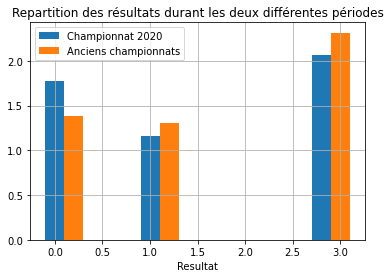

In [865]:
df_2020['Result'].hist(bins=15, label = 'Championnat 2020', align = 'left', density = True)
df['Result'].hist(bins=15, label = 'Anciens championnats', align = 'right', density = True)
plt.title('Repartition des résultats durant les deux différentes périodes')
plt.xlabel("Resultat")
plt.legend()
plt.show()

On constate en effet que la proportion de victoires à l'extérieur est plus élevée dans le championnat 2020. Cela vient du fait que les supporters ne sont plus autorisés dans les stades à cause de la crise sanitaire : cela fait ques les équipes à domicile, habituellement soutenues lorsqu'elles jouent chez elles, n'ont plus le "douzième homme" qui les pousse à se surpasser. Cet évènement n'avait pas été anticipé par les bookmakers, ou du moins a été sous-estimé, ce qui fait que les stratégies qui consistaient à miser sur les victoires à l'extérieur marchaient bien en cette période particulière. On peut d'ailleurs le vérifier :

In [866]:
print(np.mean(data_ligue_1_2017['B365A']),np.mean(data_ligue_1_2018['B365A']),np.mean(df_2020['B365A']))

5.085763157894736 4.45728947368421 3.9110294117647055


La moyenne des côtes à l'extérieur a légèrement baissé entre 2018 et 2020, mais rien de significatif : de tels ecarts étaient déjà observés entre 2017 et 2018, sans changement particulier.
Tout cela fait que nous avons peut-être juste eu de la chance d'avoir des métriques à l'éxtérieur encourageantes et que nous soyons partis dans cette voie. Maintenant que les bookmakers ont conscience de ce phénomène, rien ne nous dit que notre méthode va pouvoir rester éternellement fiable. Seul le temps nous le dira.

Malgré tout, nos résultats sans encourageants, et il est sûr qu'il est possible de les améliorer. C'est ce que nous allons essayer de faire en Partie 3.

In [867]:

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.49      0.43      0.46       111
           1       0.00      0.00      0.00       125
           3       0.49      0.86      0.63       187

    accuracy                           0.49       423
   macro avg       0.33      0.43      0.36       423
weighted avg       0.35      0.49      0.40       423



## **Partie 3 : Optimisation**

Dans cette partie, l'objectif sera d'explorer différentes pistes afin d'essayer de pousser les performances de notre modèle au maximum afin d'obtenir les meilleurs résultats possibles.

### A) La prédiction des matchs nuls

Premièrement, attardons nous sur le problème des mauvaises prédiction de matchs nuls. Nous avions vu en partie 1 que notre modèle obtenait des métriques égales à 0 pour les matchs nuls : cela est récurrent dans les problèmes de classification et indique généralement que notre modèle ne prédit pas de matchs nuls (Result = 1).

Essayons de regarder les métriques de notre modèle d'apprentissage : 

In [868]:
Y_pred_train = lr.predict(X_train)
print(classification_report(Y_train, Y_pred_train))

              precision    recall  f1-score   support

           0       0.49      0.38      0.43       278
           1       0.00      0.00      0.00       243
           3       0.52      0.87      0.65       465

    accuracy                           0.52       986
   macro avg       0.34      0.42      0.36       986
weighted avg       0.38      0.52      0.43       986



On remarque que même dans le dataset d'apprentissage, notre modèle ne prédit bien aucun match nul.
Comme nous l'avons dit, on a là un problème courant dans les problèmes de classification : notre modèle va avoir tendance à s'adapter aux probabilités "inhérentes" à chaque évènement. 
Ici, la probabilité qu'une équipe à domicile gagne est clairement plus élevée : nous avons vu que dans notre dataset, cela correspondait à 52% des observations. Ainsi, un modèle qui ne fait que prédire des victoires obtiendrait un 100% de recall sur les victoires et un recall total de 52%. c'est d'ailleurs exactement le weighted average du recall de notre modèle.
Essayons de visualiser graphiquement nos prédictions :

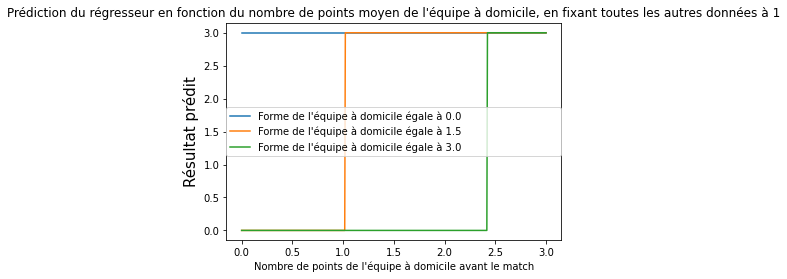

In [869]:
v=[]
for k in np.linspace(0,3,3):
    a = np.linspace(0,3,500)
    b = lr.predict(pd.DataFrame(np.c_[[a,k*np.ones(500),np.ones(500),np.ones(500)]]).transpose())
    plt.plot(a, b, label="Forme de l'équipe à domicile égale à %s" % (k))
    plt.legend(loc='best',
           ncol=1, mode="expand", borderaxespad=0.)

    
plt.title("Prédiction du régresseur en fonction du nombre de points moyen de l'équipe à domicile, en fixant toutes les autres données à 1", loc='center')
plt.xlabel("Nombre de points de l'équipe à domicile avant le match")
plt.ylabel('Résultat prédit', size=15)
plt.show()




On remarque bien sur la graphique que à Points Moyens et Forme de l'équipe à l'extérieur fixés, nos prédictions passent directement de 0 à 3 quand notre nombre de points à domicile augmente. Cela illsutre bien le fait qu'on ne passe jamais par la valeur 1, donc il semble bien que notre modèle ne prédise que des victoires ou des défaites, mais jamais de matchs nuls. Pour en être sur, nous pouvons représenter graphiquement nos prediction sur l'échantillon Test :

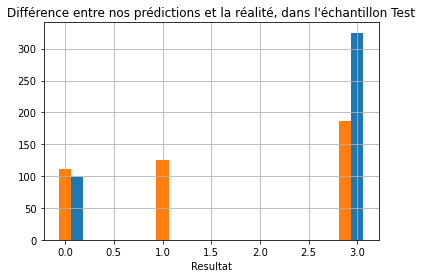

In [870]:
ax = pd.DataFrame(Y_pred).hist(bins=24, label="Prediction", align="right")
pd.DataFrame(Y_test).hist(bins=24, label="Réalité", ax=ax, align="left")
plt.title("Différence entre nos prédictions et la réalité, dans l'échantillon Test")
plt.xlabel('Resultat')
plt.show()

On remarque immédiatement que notre modèle ne prédit aucun "1" donc aucun match nul. Cependant il prédit bien des victoires à l'extérieur, comme nous l'avons vu précédement, dans un nombre relativement proche de leur nombre d'origine.

In [871]:
display(1 - np.count_nonzero(Y_pred_train)/len(Y_pred_train))

0.2210953346855984

Il prédit 22% de victoires à l'extérieur, pour être précis. On a donc 78% de nos prédictions qui sont des victoires à domicile, ce qui est assez élevé.
Peut être que cette absence de prédictions de matchs nuls vient du fait que nos variables explicatives expliquent très mal le phénomène de match nul. Essayons de rajouter des variables explicatives à notre modèle. 
On pourrait par exemple rajouter une donnée qui serait le nombre de matchs nuls moyens réalisé par chaque équipe avant leur match. 
Tout d'abord, implémentons cette donnée dans df, à la manière de nos colonnes crées dans la partie 1.


In [872]:
df['DrawsHomeTeam'] = np.zeros(len(df)) 
df['DrawsAwayTeam'] = np.zeros(len(df))

for team in df.drop_duplicates(['HomeTeam'])['HomeTeam']: 
  
  average_draws_team = 0.29
  nb_matches = 1

  for k in range(len(df)): 

    if df['HomeTeam'].iloc[k] == team : 
      
      df['DrawsHomeTeam'].iloc[k] = average_draws_team
       
      r = float(df['Result'].iloc[k]==1) # renvoie 1 si match nul, 0 sinon

      average_draws_team = (average_draws_team*nb_matches + r)/(nb_matches+1)
      
      nb_matches = nb_matches+1
    
    if df['AwayTeam'].iloc[k] == team : 
      
      df['DrawsAwayTeam'].iloc[k] = average_draws_team

      r = float(df['Result'].iloc[k]==1)

      average_draws_team = (average_draws_team*nb_matches + r)/(nb_matches+1) 
      
      nb_matches = nb_matches+1

    if nb_matches >= 39 : 
      nb_matches = 1 

    
display(df)

,Date,HomeTeam,AwayTeam,Result,PtsHomeTeam,PtsAwayTeam,FormHomeTeam,FormAwayTeam,DrawsHomeTeam,DrawsAwayTeam
0,19/08/16,Lyon,Caen,3,2.195000,2.195000,1.712,1.712,0.290000,0.290000
1,20/08/16,Angers,Nice,0,0.695000,2.195000,1.112,1.712,0.290000,0.290000
2,20/08/16,Lille,Dijon,3,0.695000,0.695000,1.112,1.112,0.290000,0.290000
3,20/08/16,Lorient,Bastia,0,0.695000,0.695000,1.112,1.112,0.290000,0.290000
4,20/08/16,Nantes,Monaco,0,2.195000,1.195000,1.712,1.312,0.290000,0.290000
...,...,...,...,...,...,...,...,...,...,...
1404,07/03/2020,Nice,Monaco,3,1.409741,1.463475,1.200,2.200,0.306969,0.270853
1405,07/03/2020,Reims,Brest,3,1.408782,1.263929,1.200,1.200,0.407775,0.367500
1406,08/03/2020,St Etienne,Bordeaux,1,1.097476,1.324588,0.200,1.200,0.193985,0.343935
1407,08/03/2020,Rennes,Montpellier,3,1.727583,1.483823,1.400,1.400,0.197760,0.272999


Notre implémentation a bien fonctionné : on remarque notament que Reims, reputée réputée pour faire beaucoup de matchs nuls, est à 40 %, ce qui est très proche des valeurs que l'on peut trouver sur Internet (pas exactement la même car nos indicateurs sont construits sur plusieurs championnats).
Etablissons un nouveau modèle :

In [873]:
X_D = df[['PtsHomeTeam','PtsAwayTeam', 'FormHomeTeam', 'FormAwayTeam', 'DrawsHomeTeam', 'DrawsAwayTeam']]

X_train_D, X_test_D, Y_train_D, Y_test_D = train_test_split(X_D, Y, test_size = 0.3, random_state=7)
lr_draws = LogisticRegression()
lr_draws.fit(X_train_D, Y_train_D)
display(lr_draws.predict(X_test_D[:5]))

array([3, 3, 3, 0, 0])

On remarque que l'implémentation de ces données ne change rien à nos prédictions précédente. Pour le 4 ème match, dont le résultat est un match nul, nous prédisons encore une victoire de l'équipe à l'extérieur, donc nous nous loupons encore la prédiction d'un match nul.
Regardons à nouveau les métriques d'évaluation : 

In [874]:
Y_pred_D = lr_draws.predict(X_test_D)
print(classification_report(Y_test_D, Y_pred_D))

              precision    recall  f1-score   support

           0       0.48      0.42      0.45       111
           1       0.00      0.00      0.00       125
           3       0.49      0.84      0.62       187

    accuracy                           0.48       423
   macro avg       0.32      0.42      0.36       423
weighted avg       0.34      0.48      0.39       423



On voit que l'implémentation de ces nouvelles données ne change quasiment rien à nos résultats. On a encore des métriques égales à 0 pour les matchs nuls.

Les matchs nuls sont donc des évènements trop aléatoires pour être correctement prédits. En effet, les matchs nuls sont des évènements qui sont relativement rares car "ils tiennent à un but". Les buts au football restent des évènements fondamentalement aléatoires et incertains et donc il est très risqué de se risquer à se prédire à des égalités. 

En réalité, il n'est pas si surprenant que notre modèle ne prédise jamais de matchs nuls. Si on regarde les sites de paris, on remarque que la côte du match nul est systématiquement plus élevée que la côte du favori. Cela veut dire que les sites de paris estiment qu'il y a toujours plus de chances pour qu'une des deux équipes gagne plutôt qu'il y ait match nul.

In [875]:
df_2020['Cote_du_favori']=df_2020[['MaxA','MaxH']].apply(min, axis = 1)
df_2020[df_2020['Cote_du_favori']>df_2020['MaxD']]

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Result,PtsHomeTeam,PtsAwayTeam,FormHomeTeam,FormAwayTeam,Prediction,Cote,Mise,Benefice,Cote_du_favori


Il n'y a aucun endroit ou la côite du favori est supérieur à la côte du match nul.
Ainsi, si les sites de paris eux-mêmes devaient parier, ils ne prédiraient jamais de match nuls.

Cependant, il est tout de même possible d'assigner une probabilité à cet évènement incertain : elle sera très souvent faible certes, mais existante.
Il devient alors ici important de préciser ce que "battre" un site de paris sportifs veut clairement dire.

### B) Battre un site de paris sportifs

Jusqu'ici nous avons été relativement flous sur cette notion. Mais concrètement, pour battre un site de paris sportifs, il ne faut pas vraiment "bien deviner" le résultat des matchs, comme on le laissait entendre à la fin de la partie 1 dans un soucis de simplification. Il s'agit de mieux connaître les probabilités réelles du résultats d'un match que le site de paris sportifs. 
L'existence de côtes rend en effet le système de paris beaucoup plus fluide : on peut avoir une epserance de gains positive même si la plupart de nos prédictions sont incorrectes. Si nous parrions sur des résultats avec de très grandes côtes, ce sont, comme on l'a vu en partie 2, des évènements très incertains. Mais si la côte qui y est associée est assez grande, alors il peut être rentable (en moyenne) de parier sur ce match.
Par exemple, si selon notre modèle, Dijon n'a que 10% de battre Paris, mais que la côte est à 15, alors l'espérance de gains est de +1,5 fois notre mise.

Lorsque nous pensons que les probabilités d'un résultat sont plus grandes que ce que prédit le site de paris sportifs, alors nous avons un "value bet". Si nous avons raison, alors à terme, nous devrions avoir une espérance de gain positive, selon la loi faible des grands nombres. Or nous savons que la côte que propose un site de paris sportifs est toujours le reflet des probabilités qu'il attribue à chaque évènement, commme nous l'avons vu en Partie 2. Et nous savons aussi que notre modèle nous prédira toujours le Résultat dont la valeur est la plus probable, et non pas forcément des Value Bet. En réalité, nous jouions n'importe comment en partie 2, ou plutôt de manière très incertaine. 

Prenons un exemple : même si notre régresseur prédit bien une victoire du Paris Saint Germain, ce qui est intéréssant serait de connaître la probabilité qu'il associait à cette prediction : si elle est plus faible que la probabilité prédite par le site de paris sportifs, alors nous n'avons pas intérêt à parier sur le PSG, car cela nous donnera une espérance de gains négatives, alors que nous avons raison. 

Pour être concret, si notre modèle prédit parfaitement la probabilité que Paris gagne son match contre, par exemple, Dijon, qui est égale à 70%, mais que le site de paris sportifs a mis une côte à 1.15 pour la victoire de Paris, alors cela veut dire que le site de paris sportifs pense que la proba est de 0.85/1.15 (selon la partie 2) soit 74%. Cela veut alors dire qu'on n'a pas intérêt à parier, en témoigne ce calcul :


In [876]:
np.random.binomial(1000, 0.70)*1.15-1000 # On mise 1000 fois 1 euro sur un évènement qui a un probabilité 0.70 de se réaliser.


-180.05000000000007

Cela montre bien que même si Paris est le résultat le plus probable, on n'a pas intérêt à miser dessus. Il est donc **primordial** de connaître les probabilités prédites par notre modèle pour pouvoir parier efficacement.
Cela tombe bien, la fonction predict d'une classification linéaire peut nous donner les probabilités associées à chaque évènement, ce qui sera bien plus intéréssant dans notre cadre de paris.

In [877]:
display(lr_draws.predict_proba(X_test_D.head()),lr.predict_proba(X_test.head()))

array([[0.27719476, 0.27760551, 0.44519973],
       [0.0983092 , 0.1738826 , 0.7278082 ],
       [0.32328405, 0.26571856, 0.41099738],
       [0.43299573, 0.26380845, 0.30319582],
       [0.41267983, 0.24433202, 0.34298815]])

array([[0.27873042, 0.28144803, 0.43982155],
       [0.10048818, 0.17880643, 0.72070539],
       [0.31933412, 0.26687817, 0.41378771],
       [0.44092966, 0.25412393, 0.30494642],
       [0.41781785, 0.24015495, 0.3420272 ]])

On obtient ici les probabilités associées aux différents résultats des premiers matchs de l'échantillon test. On remarque que ces probabilités varient très peu entre nos deux modèles, on va donc utiliser le premier, car il utilise moins de features. A l'aide de cette option, nous allons pouvoir adopter une nouvelle stratégie, censée être bien plus efficace.

### *Strategie 4 : Miser sur des value bets*

Le principe de cette stratégie consiste à ne miser que quand nous prédisons qu'un résultat a plus de chances de se produire que ce que prévoit le site de paris sportifs. Pour cela, nous convertissons nous probabilités en côtes, et si la côte du site de paris sportifs est plus grande sur un évènement que la notre, alors cela veut dire qu'il sous estime les chances de l'évènement et donc qu'on a intérêt à miser dessus. 

In [893]:
def chercheur_value_bet(x) : # Nous devons définir une fonction qui cherchera la prédiction à faire en suivant
    # Notre stratégie de value_bet. Nous cherchons la côte du site de paris sportifs dont la différence avec
    # la notre est la plus élevée.
    
    a = max(x.MaxH-x.CotePrediteH, x.MaxD-x.CotePrediteD, x.MaxA-x.CotePrediteA, 0)
    
    if a == x.MaxH-x.CotePrediteH :
        return(3)
    elif a == x.MaxD-x.CotePrediteD :
        return(1)
    elif a == x.MaxA-x.CotePrediteA :
        return(0)
    else :
        return(3) # On mise sur l'equipe à domicile si jamais on ne trouve aucun value bet


def strategie_4(dataframe, model=lr): #Nous pouvons désormais appliquer notre stratégie à notre DataFrame principal.
    
    for k in ['CotePrediteH','CotePrediteD','CotePrediteA']:
        dataframe[k] = np.zeros(len(dataframe))# Nous créons des colonnes de Côte Prédite.
    
    dataframe[['CotePrediteH','CotePrediteD','CotePrediteA']] = 0.85/(model.predict_proba(dataframe[['PtsHomeTeam', 'PtsAwayTeam', 'FormHomeTeam', 'FormAwayTeam']])) 
    # Nous remplissons ces colonnes fraichement créées.
    
    dataframe['Prediction'] = dataframe.apply(chercheur_value_bet, axis=1)
    
    dataframe['Cote'] = dataframe.apply(chercheur_cote, axis=1) 
    
    dataframe['Mise'] = 1 # Ici, nous misons 1 euro à chaque fois.
    
    dataframe['Benefice'] = dataframe.apply(benefices_pari, axis = 1)
    
    return(dataframe)

    
df_2020_strategie_4 = strategie_4(df_2020)

display(df_2020_strategie_4[['HomeTeam', 'AwayTeam', 'Prediction', 'Cote', 'Result', 'Benefice']])


,HomeTeam,AwayTeam,Prediction,Cote,Result,Benefice
0,Bordeaux,Nantes,0,3.38,1,-1.00
1,Dijon,Angers,0,2.92,0,1.92
2,Lille,Rennes,0,3.60,1,-1.00
3,Monaco,Reims,0,4.50,1,-1.00
4,Lorient,Strasbourg,0,3.05,3,-1.00
...,...,...,...,...,...,...
133,Lorient,Nimes,0,3.50,3,-1.00
134,Nantes,Dijon,0,5.00,1,-1.00
135,Strasbourg,Metz,0,4.09,1,-1.00
136,Lille,Bordeaux,0,5.75,3,-1.00


On commence par remarquer que l'on mise beaucoup plus sur des matchs nuls qu'avant, alors que notre modèle n'en prédit aucun. On remarque aussi que les -1 semblent encore plus nombreux que précément, mais on remarque aussi que nos bénéfices sont souvent plus élevés : on mise en général sur des côtes plus hautes que nos 3 première stratégies. Une fois de plus, regardons ce que cela donne sur l'ensemble du championnat 2020 :

In [894]:
print('Nombre de matchs:',len(df_2020_strategie_4), '/Benefices :', sum(df_2020_strategie_4['Benefice']),'€')

Nombre de matchs: 138 /Benefices : -0.2299999999999951 €


Le résultat est un peu decevant : nous gagnons moins d'argent que dans nos premières stratégies.
Cela vient peut être du fait que nous sommes très imprécis sur la prédiction de matchs nuls, et donc sur l'estimation de leurs probabilités réelles.

### *Stratégie 5 : Miser sur les value bets extérieur*

Comme dans la Partie 2, on peut essayer d'écarter les paris sur lesquels on sait qu'on est imprécis, ici, les matchs nuls et les victoires à domicile.

In [556]:
df_2020_strategie_5 = df_2020_strategie_4[df_2020_strategie_4['Prediction'] == 0]
print('Nombre de matchs:',len(df_2020_strategie_5), '/Benefices :', sum(df_2020_strategie_5['Benefice']),'€')

Nombre de matchs: 90 /Benefices : 9.81 €


On voit que nous arrivons à redevenir gagnants en ne misant que sur les victoires à l'extérieur : une fois de plus, cela peut tou simplement s'expliquer par le fait que 2020 était une bonne année pour miser à l'extérieur.

### *Stratégie 6 : Faire varier les mises*

Nous pouvons essayer d'aller encore plus loin et tenter de jouer sur nos value bets pour obtenir de meilleurs résultats. Tous les value bets n'ont pas la même valeur : dans ceratins cas, la côte du site de paris sportifs est assez proche de ce que nous prédisons, defois, l'écart est plus grand. On pourrait alors essayer d'adapter nos mises en fonction de nos value_bet : plus le site de paris sportifs se trompe par rapport à nos prédictions, plus on va miser gros.

In [569]:

def calculateur_mise(x):
    P = Resultat_inverse(x.Prediction) 
    delta = x['Max'+ P] - x['CotePredite'+ P]
    return(delta) # Plus l'écart est grand, plus notre mise est grande (la focntion identité a été définie arbitrairement)

def strategie_6(dataframe): #Nous pouvons désormais appliquer notre stratégie à notre DataFrame principal.
    
    dataframe[['CotePrediteH','CotePrediteD','CotePrediteA']] = 0.85/(lr.predict_proba(dataframe[['PtsHomeTeam', 'PtsAwayTeam', 'FormHomeTeam', 'FormAwayTeam']])) 
    # Nous créons des colonnes de Côte Prédite.
    
    dataframe['Prediction'] = dataframe.apply(chercheur_value_bet, axis=1)
    
    dataframe['Cote'] = dataframe.apply(chercheur_cote, axis=1) 
    
    dataframe['Mise'] = dataframe.apply(calculateur_mise, axis=1) # Ici, nous faisons varier les mises
    
    dataframe['Benefice'] = dataframe.apply(benefices_pari, axis=1)
    
    return(dataframe)

    
df_2020_strategie_6 = strategie_6(df_2020)

display(df_2020_strategie_6[['HomeTeam', 'AwayTeam', 'Prediction', 'Cote', 'Result','Mise', 'Benefice']])


,HomeTeam,AwayTeam,Prediction,Cote,Result,Mise,Benefice
0,Bordeaux,Nantes,0,3.38,1,1.604657,-1.604657
1,Dijon,Angers,0,2.92,0,0.788559,1.514034
2,Lille,Rennes,0,3.60,1,1.855358,-1.855358
3,Monaco,Reims,0,4.50,1,2.695165,-2.695165
4,Lorient,Strasbourg,0,3.05,3,1.239256,-1.239256
...,...,...,...,...,...,...,...
123,Bordeaux,Brest,0,3.65,3,1.744512,-1.744512
124,Dijon,St Etienne,3,3.08,1,0.643746,-0.643746
125,Nantes,Strasbourg,0,3.51,0,1.972497,4.950968
126,Reims,Nice,3,2.59,1,0.586133,-0.586133


On voit que nos bénéfices sont encore plus variables, et il semble qu'ils ne s'équilibrent pas vraiment.

In [567]:
print('Nombre de matchs:',len(df_2020_strategie_6), '/Benefices :', sum(df_2020_strategie_6['Benefice']),'€')

Nombre de matchs: 128 /Benefices : -152.9429005151428 €


Ici, il est clair que la stratégie est mauvaise : cette méthode exacerbe nos erreurs d'estimation, et donc lorsque l'on fait des erreurs, celles-ci coûtent plus cher. Essayons de regarder ce que donnent nos bénéfices uniquement sur les victoires à l'extérieur, pour voir si ces pertes importantes proviennent, comme la dernière fois, de l'imprecision de notre modèle pour prédire les matchs nuls.

### *Stratégie 7 : Miser sur les value bets extérieurs en faisant varier les mises*


In [568]:
df_2020_strategie_7 = df_2020_strategie_6[df_2020_strategie_6['Prediction'] == 0]
print('Nombre de matchs:',len(df_2020_strategie_7), '/Benefices :', sum(df_2020_strategie_7['Benefice']),'€')

Nombre de matchs: 90 /Benefices : -126.47759955435144 €


Nous semblons perdants, une fois de plus. On en conclut donc que c'est une mauvaise idée de faire varier nos mises en fonction croissante de l'écart de la côte de notre value bet et de la côte du pari sportif : bien souvent, quand cette différence est grande, il s'agira d'une erreur d'véaluation de notre part, et non pas d'une erreur d'évaluation du site de paris sportifs.

Nous pourrions alors essayer d'adopter des stratégies qui consisteraient à lisser les risques que l'on prend, c'est à dire faire varier nos mises de manière décroissante avec l'écart des côtes : on part du principe que c'est sûrement nous qui nous trompons, et non pas le site de paris sportifs.

### *Stratégie 8 : Faire varier les mises...différement*

In [571]:
import math

def calculateur_mise_2(x):
    P = Resultat_inverse(x.Prediction) 
    delta = x['Max'+ P] - x['CotePredite'+ P]
    return(1/math.sqrt(delta)) # Principe de précaution : Plus l'écart est grand, plus notre mise est petite (la focntion identité a été définie arbitrairement)

def strategie_8(dataframe): #Nous pouvons désormais appliquer notre stratégie à notre DataFrame principal.
    
    dataframe[['CotePrediteH','CotePrediteD','CotePrediteA']] = 0.85/(lr.predict_proba(dataframe[['PtsHomeTeam', 'PtsAwayTeam', 'FormHomeTeam', 'FormAwayTeam']])) 
    # Nous créons des colonnes de Côte Prédite.
    
    dataframe['Prediction'] = dataframe.apply(chercheur_value_bet, axis=1)
    
    dataframe['Cote'] = dataframe.apply(chercheur_cote, axis=1) 
    
    dataframe['Mise'] = dataframe.apply(calculateur_mise_2, axis=1) # Ici, nous faisons varier les mises
    
    dataframe['Benefice'] = dataframe.apply(benefices_pari, axis=1)
    
    return(dataframe)

    
df_2020_strategie_8 = strategie_8(df_2020)

display(df_2020_strategie_8[['HomeTeam', 'AwayTeam', 'Prediction', 'Cote', 'Result','Mise', 'Benefice']])

,HomeTeam,AwayTeam,Prediction,Cote,Result,Mise,Benefice
0,Bordeaux,Nantes,0,3.38,1,0.789421,-0.789421
1,Dijon,Angers,0,2.92,0,1.126115,2.162141
2,Lille,Rennes,0,3.60,1,0.734152,-0.734152
3,Monaco,Reims,0,4.50,1,0.609126,-0.609126
4,Lorient,Strasbourg,0,3.05,3,0.898296,-0.898296
...,...,...,...,...,...,...,...
123,Bordeaux,Brest,0,3.65,3,0.757117,-0.757117
124,Dijon,St Etienne,3,3.08,1,1.246358,-1.246358
125,Nantes,Strasbourg,0,3.51,0,0.712019,1.787169
126,Reims,Nice,3,2.59,1,1.306176,-1.306176


In [572]:
print('Nombre de matchs:',len(df_2020_strategie_6), '/Benefices :', sum(df_2020_strategie_6['Benefice']),'€')

Nombre de matchs: 128 /Benefices : 5.429935756075853 €


In [573]:
df_2020_strategie_9 = df_2020_strategie_8[df_2020_strategie_8['Prediction'] == 0]
print('Nombre de matchs:',len(df_2020_strategie_9), '/Benefices :', sum(df_2020_strategie_9['Benefice']),'€')

Nombre de matchs: 90 /Benefices : 14.78402128885633 €


On obtient alors de très bon résultats. Le taux de retour sur investissement est clairement moins élevé qu'en partie 2, certes, mais cela s'explique par le fait qu'on minimise les risques avec notre principe de précaution.
Il semble donc qu'on ait bel et bien trouvé une méthode qui semble plutôt fiable pour gagner d el'argent à l'aide de notre modèle.

### C) Changement d'indicateurs ?

Dès le début du projet, nous avons décidé de travailler avec le nombre de points moyen de chaque équipe. Désormais, nous pouvons essayer de remettre en question ce choix : aurait-on obtenu de meilleurs résultats en créant des indicateurs différents pour chaque équipe ? Par exemple, si nous avions pris le nombre de points au lieu du nombre moyen de points, nous aurions :

In [622]:
df['PtsHomeTeam'] = np.zeros(len(df)) 
df['PtsAwayTeam'] = np.zeros(len(df))

for team in df.drop_duplicates(['HomeTeam'])['HomeTeam']:
  
  pts_team = 0
  nb_matches = 0

  for k in range(len(df)): 
        
    if df['HomeTeam'].iloc[k] == team : 
      
      df['PtsHomeTeam'].iloc[k] = pts_team
       
      r = df['Result'].iloc[k] 

      pts_team = (pts_team + r)
    
      nb_matches = nb_matches+1
    
    if df['AwayTeam'].iloc[k] == team : 
        
      df['PtsAwayTeam'].iloc[k] = pts_team

      r = df['Result'].iloc[k]

      pts = (1/2)*r**2 - (5/2)*r + 3 # Attention, il faut bien appliquer une fonction à r car ici on compte les points de l'equipe à l'extérieur. Cette fonction est la fonction la plus simple vérifiant f(3)=0, f(1)=1, f(0)=3.
      
      pts_team = pts_team + pts
      
      nb_matches = nb_matches+1

    if nb_matches >= 38 : 
      nb_matches = 0
      pts_team = 0
   
display(df)



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Date,HomeTeam,AwayTeam,Result,PtsHomeTeam,PtsAwayTeam,FormHomeTeam,FormAwayTeam,DrawsHomeTeam,DrawsAwayTeam
0,19/08/16,Lyon,Caen,3,0.0,0.0,1.712,1.712,0.290000,0.290000
1,20/08/16,Angers,Nice,0,0.0,0.0,1.112,1.712,0.290000,0.290000
2,20/08/16,Lille,Dijon,3,0.0,0.0,1.112,1.112,0.290000,0.290000
3,20/08/16,Lorient,Bastia,0,0.0,0.0,1.112,1.112,0.290000,0.290000
4,20/08/16,Nantes,Monaco,0,0.0,0.0,1.712,1.312,0.290000,0.290000
...,...,...,...,...,...,...,...,...,...,...
1404,07/03/2020,Nice,Monaco,3,35.0,40.0,1.200,2.200,0.306969,0.270853
1405,07/03/2020,Reims,Brest,3,38.0,34.0,1.200,1.200,0.407775,0.367500
1406,08/03/2020,St Etienne,Bordeaux,1,26.0,36.0,0.200,1.200,0.193985,0.343935
1407,08/03/2020,Rennes,Montpellier,3,44.0,40.0,1.400,1.400,0.197760,0.272999


In [623]:
X_new = df[['PtsHomeTeam','PtsAwayTeam', 'FormHomeTeam', 'FormAwayTeam', 'DrawsHomeTeam', 'DrawsAwayTeam']]

X_train_new, X_test_new, Y_train_new, Y_test_new = train_test_split(X_new, Y, test_size = 0.3, random_state=7)
lr_new = LogisticRegression()
lr_new.fit(X_train_new, Y_train_new)
display(lr_new.predict(X_test_new.head()))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([3, 3, 0, 0, 0])

Ici, les predictions sur notre échantillon test changent : mais pas dans le bon sens, étant donné qu'on se trompe sur un match supplémentaire.

In [624]:
Y_pred_new = lr_new.predict(X_test_new)
print(classification_report(Y_test_new, Y_pred_new))

              precision    recall  f1-score   support

           0       0.43      0.35      0.39       111
           1       0.00      0.00      0.00       125
           3       0.49      0.87      0.63       187

    accuracy                           0.48       423
   macro avg       0.31      0.41      0.34       423
weighted avg       0.33      0.48      0.38       423



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Il semble que nos métriques d'évaluation sont un peu moins bonnes que précédemment. La différence n'est pas grande, mais il semble bien que notre indicateur de points moyens est plus pertinent que simplement l'indicateurs du nombre de points.

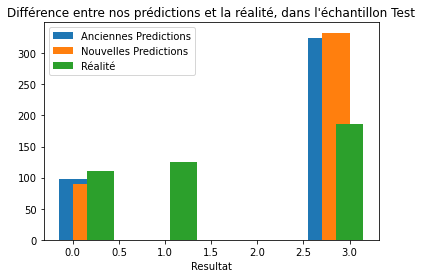

In [655]:
plt.hist(Y_pred, label="Anciennes Predictions", align='left')
plt.hist(Y_pred_new, label="Nouvelles Predictions", align='mid')
plt.hist(Y_test,label="Réalité", align='right')
plt.title("Différence entre nos prédictions et la réalité, dans l'échantillon Test")
plt.xlabel('Resultat')
plt.legend()
plt.show()

Ce graphique montre assez clairement que nos anciennes prédictions collaient un petit peu mieux à la réalité que les nouvelles.

### D) Score de validation croisée , préprocessing et hyperparamètres 

Pour finir cette partie d'optimisation, nous allons essayer d'utiliser des fonctionnalités plus avancées de skicit learn afin d'utiliser des méthodes plus perfectionnées et précises de Machine Learning.
##### a) Score de validation croisée

Nous pouvons tout d'abord nous demander si notre Régression Logistique était le modèle le plus efficace à appliquer. Essayons de voir ce que nous obtenons pour une RandomForest.

In [676]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
Y_pred_rf = rf.predict(X_test)
print(classification_report(Y_test, Y_pred_rf))


              precision    recall  f1-score   support

           0       0.32      0.38      0.35       111
           1       0.23      0.12      0.16       125
           3       0.47      0.57      0.51       187

    accuracy                           0.39       423
   macro avg       0.34      0.36      0.34       423
weighted avg       0.36      0.39      0.37       423



Il semble que la RandomForest soit légèrement meilleure : on remarque que la precision moyenne est plus élevée que pour la classifcation linéaire, et notre modèle prédit désormais des matchs nuls, de manière plutôt précise au vu de leur incertitude. Cependant, nous avons vu en A) de la partie 3 que ce n'était pas frocément une bonne chose que notre modèle se mette à prédire des matchs nuls. On remarque aussi que la precision des victoires à l'extérieur a grandement baissé.

Il est donc assez difficile d'estimer qui entre la régresison et la RandomForest est la meilleure. Pour essayer de disciminer un des deux modèles, nous pouvons utiliser le score de validation croisée, qui va permettre de rendre les résultats indépendants de notre X_test et Y_test.

In [684]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore") # Nous allons ici cacher des messages warnings qui sont très nombreux, dans un soucis d'esthétique et de présentation.

from sklearn.model_selection import cross_val_score

print(cross_val_score(RandomForestClassifier(), X, Y, cv=5, scoring='precision_weighted').mean(), cross_val_score(LogisticRegression(), X, Y, cv=5, scoring = 'precision_weighted').mean()) 




0.4080379601223553 0.42155434695324995


Une fois de plus, les résultats ne sont pas vraiment disciminants. Ici, nous avons pris un cv égal à 5-fold. Peut-être qu'en faisant varier cette valeur, nous pourrions obtenir une valeur de cv discriminante.
Regardons tout de même sur plusieurs valeurs de k

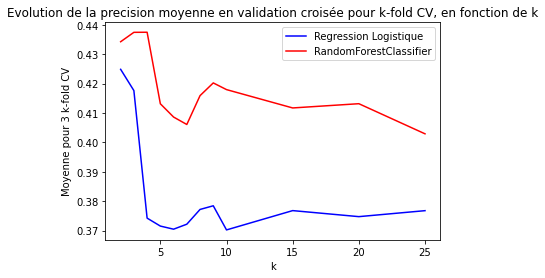

In [803]:
def moyenne_score(modèle, k, n):
    v = []
    for i in range(n):
        v.append(cross_val_score(modèle, X, Y, cv=k, scoring='precision_weighted').mean())
    return np.mean(v) # Pour que nos résultats soient moins variables, on définit une fonction qui permet de faire la moyenne
#de différents scores de validation croisée, car ces scores sont aléatoires.

a = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]
v = [np.array(moyenne_score(LogisticRegression(), k, 3)) for k in a] # Ici on ne fait une moyenne que sur 3 échantillons car notre programme 
#met déjà environ 1 minute à s'éxecuter.
u = [np.array(moyenne_score(RandomForestClassifier(), k, 3)) for k in a]
plt.figure()
plt.title('Evolution de la precision moyenne en validation croisée pour k-fold CV, en fonction de k')
plt.plot(a, v, '-b', label='Regression Logistique')
plt.plot(a, u, '-r', label='Random Forest')
plt.xlabel('k')
plt.ylabel('Moyenne pour 3 k-fold CV')
plt.legend()
plt.show()

On voit que la régression logistique semble être la meilleure pour un k égal à 2. Par la suite la Random Forest prend le dessus mais ne fait jamais aussi bien que la regression. Le cross_val_score nous on a donc permis de pouvoir comparer deux méthodes de classification et choisir la meilleure.

##### b) Le pre-processing des données

La plupart des messages d'erreurs avertissent sur le fait qu'on a pas fait de préprocessing sur nos données, qui est pourtant une étape importante pour s'assurer que nos algorithmes de Machine Learning fonctionnent bien. Nous allons appliquer un preprocessing à X et voir ce que cela change sur nos resultats.
Un preprocessing consiste à transformer X de manière à lui donner la répartition que l'on souhaite : génèralement, une forme de Gaussienne. Commençons par regarder la répartition de notre X_test.

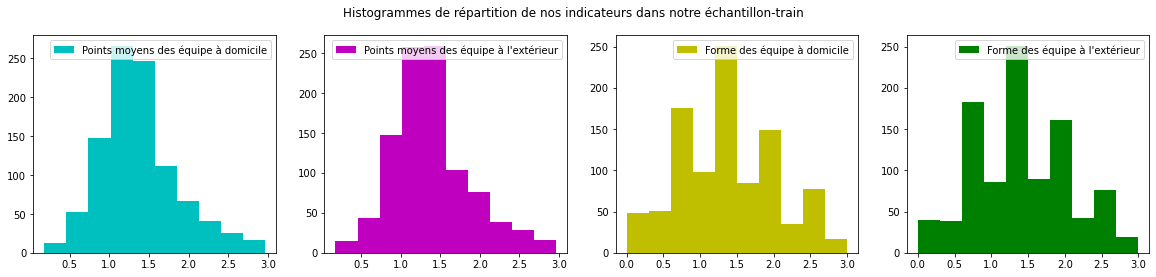

In [794]:

fig = plt.figure(figsize = (20, 4))
plt.suptitle('Histogrammes de répartition de nos indicateurs dans notre échantillon-train')
plt.subplot(141)
plt.hist(X_train['PtsHomeTeam'], color='c', label="Points moyens des équipe à domicile")
plt.legend()
plt.subplot(142)
plt.hist(X_train['PtsAwayTeam'], color='m', label="Points moyens des équipe à l'extérieur")
plt.legend()
plt.subplot(143)
plt.hist(X_train['FormHomeTeam'], color='y', label="Forme des équipe à domicile")
plt.legend()
plt.subplot(144)
plt.hist(X_train['FormAwayTeam'], color='g', label="Forme des équipe à l'extérieur")
plt.legend()
plt.show()

On remarque que les histogrammes ressemblent déjà beaucoup à des gaussiennes. On remarque tout de même que les indicateurs de forme comportent des trous, car ils ils ne peuvent sauter que de 0.3 en 0.3 (s'agissant d'une moyenne de points sur les 5 denriers matchs). Il est aussi rassurant de voir que les indicateurs à domicile et les indicateurs à l'extérieur sont globalement les mêmes, que ce soit pour les points ou la forme : ils représentent, à l'échelle macroscopique, à peu près la même chose, comme chaque equipe alterne entre jouer à domicile et à l'extérieur, ces idnciateurs contiennent les datas de toutes les équipes.

Essayons désormais d'appliquer un préprocessing à ces données :

                  0             1             2             3
count  9.860000e+02  9.860000e+02  9.860000e+02  9.860000e+02
mean   6.429385e-17 -1.154137e-16  3.413992e-16 -2.043103e-16
std    1.000507e+00  1.000507e+00  1.000507e+00  1.000507e+00
min   -2.454108e+00 -2.477647e+00 -2.053850e+00 -2.110938e+00
25%   -6.646036e-01 -6.694030e-01 -8.302176e-01 -8.852042e-01
50%   -1.210926e-01 -1.181734e-01 -1.344320e-02  3.409616e-02
75%    4.498620e-01  4.548563e-01  6.993224e-01  6.469631e-01
max    3.274864e+00  3.259578e+00  2.534770e+00  2.485564e+00


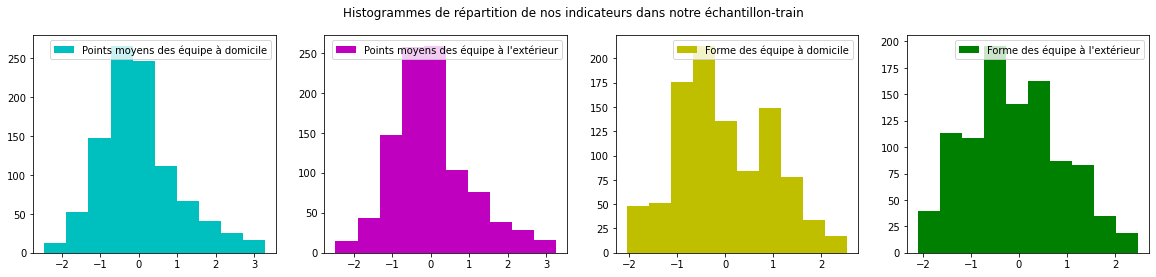

In [799]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))

print(X_train_scaled.describe())

fig = plt.figure(figsize = (20, 4))
plt.suptitle('Histogrammes de répartition de nos indicateurs dans notre échantillon-train')
plt.subplot(141)
plt.hist(X_train_scaled[0], color='c', label="Points moyens des équipe à domicile")
plt.legend()
plt.subplot(142)
plt.hist(X_train_scaled[1], color='m', label="Points moyens des équipe à l'extérieur")
plt.legend()
plt.subplot(143)
plt.hist(X_train_scaled[2], color='y', label="Forme des équipe à domicile")
plt.legend()
plt.subplot(144)
plt.hist(X_train_scaled[3], color='g', label="Forme des équipe à l'extérieur")
plt.legend()
plt.show()


Maintenant que nos données sont bien centrées réduites, nous pouvons essayer de reconstruire nos modèles.


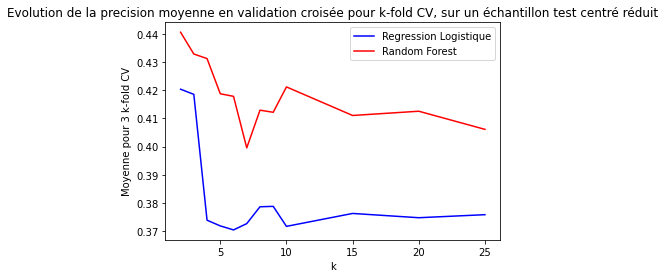

In [805]:
from sklearn.model_selection import cross_val_score

X = pd.DataFrame(scaler.transform(X))

a = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]
v = [np.array(moyenne_score(LogisticRegression(), k, 3)) for k in a] # Ici on ne fait une moyenne que sur 3 échantillons car notre programme 
#met déjà environ 1 minute à s'éxecuter.
u = [np.array(moyenne_score(RandomForestClassifier(), k, 3)) for k in a]
plt.figure()
plt.title('Evolution de la precision moyenne en validation croisée pour k-fold CV, sur un échantillon test centré réduit')
plt.plot(a, v, '-b', label='Regression Logistique')
plt.plot(a, u, '-r', label='Random Forest')
plt.xlabel('k')
plt.ylabel('Moyenne pour 3 k-fold CV')
plt.legend()
plt.show()


##### c) Jouer sur les hyperparamètres de nos algorithmes

Pour finir cette partie d'optimisation, nous pouvons essayer de jouer sur les hyperparamètres de nos modèles afin d'obtenir le meilleur modèle possible. Une fois de plus, notre métrique d'évaluation sera la precision moyenne, car c'est ce qui est le plus important quand on fait des paris sportifs.

Essayons tout d'abord d'utiliser des Arbres de décision. Le module AdaBoost nous permet de donner différentes profondeurs à nos arbres : plus l'arbre est profond, plus notre modèle fit aux données, et donc mieux il prédit celles de l'échantillon test. Cependant, le risque d'overfitting est alors assez important.

Ici, nous n'appliquons ce modèle qu'à nos X_train afin de pouvoir regarder les métriques d'évaluation de notre modèle sur l'échantillon test, échantillon dont il sera resté indépendant.

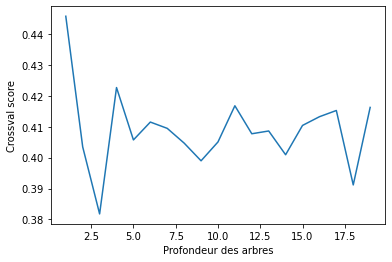

In [808]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
perf = []
for i in range(1,20):
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i))
    perf.append(cross_val_score(clf, X_train_scaled, Y_train, cv=2, scoring='precision_weighted').mean())
plt.figure()
plt.plot(np.arange(1, 20), perf)
plt.xlabel('Profondeur des arbres')
plt.ylabel('Crossval score')
plt.show()

On remarque ici que dans le cas d'un arbre de décision, on a plutôt intérêt à ce que sa profondeur soit la plus petite possible. Regardons les métriques d'évaluation pour une profondeur égale à 1 :

In [809]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
clf.fit(X_train, Y_train)
Y_pred_clf = clf.predict(X_test)
print(classification_report(Y_test, Y_pred_clf))

              precision    recall  f1-score   support

           0       0.43      0.40      0.41       111
           1       0.39      0.12      0.18       125
           3       0.50      0.75      0.60       187

    accuracy                           0.47       423
   macro avg       0.44      0.42      0.40       423
weighted avg       0.45      0.47      0.43       423



Nous arrivons à encore plus augmenter notre précision sur les matchs nuls, et nous obtenons une precision moyenne (weighted) de 0.45, ce qui est une grande amélioration par rapport à tous nos précédents modèles. Nous pourrons donc tester ce modèle et voir si nous obtenons de meilleurs résultats.

Essayons tout de même d'aller encore plus loin : AdaBoost permet en réalité de jouer sur de très nombreux paramètres des modèles de classification. Essayons de faire varier tous ces paramètres pour tester différents modèle et sélectionner le meilleur.

In [810]:
AdaBoostClassifier().get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

Ici, nous avons la liste des paramètres sur lesquels nous pouvons jouer. Définissons une grille d'hyperparamètres qui va nous permettre de les faire varier pour tous nos modèles.

In [815]:
param_grid = {'base_estimator': [DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression()],
             'learning_rate': [0.001, 0.01, 0.1, 1.0],
             'n_estimators': [50, 100, 150, 200],
             'random_state':[7]}

ATTENTION : Le modèle suivant est extrêmement long à entraîner. Le programme met une environ une heure à tourner.

In [817]:
from sklearn.model_selection import GridSearchCV

rg = GridSearchCV(AdaBoostClassifier(), param_grid=param_grid, scoring='precision_weighted')
rg.fit(X_train_scaled, Y_train) 


GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'base_estimator': [DecisionTreeClassifier(),
                                            RandomForestClassifier(),
                                            LogisticRegression()],
                         'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 150, 200],
                         'random_state': [7]},
             scoring='precision_weighted')

In [827]:
Maintenat que GridSearch a trouvé les meilleurs hyperparamètres, nous pouvons découvrir le classement des différents modèles :

SyntaxError: invalid syntax (<ipython-input-827-1e951bec46ad>, line 1)

In [826]:
results = pd.DataFrame(rg.cv_results_)
results.sort_values('rank_test_score')



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator,param_learning_rate,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,53.538628,86.139347,0.502973,0.030002,RandomForestClassifier(),0.01,50,7,"{'base_estimator': RandomForestClassifier(), '...",0.471646,0.437518,0.468074,0.434715,0.435365,0.449464,0.016718,1
21,21.942267,3.237039,1.145627,0.224154,RandomForestClassifier(),0.01,100,7,"{'base_estimator': RandomForestClassifier(), '...",0.468004,0.437518,0.461948,0.430142,0.431072,0.445737,0.016028,2
28,14.556133,0.327041,0.705169,0.014218,RandomForestClassifier(),1,50,7,"{'base_estimator': RandomForestClassifier(), '...",0.441789,0.427437,0.439329,0.445279,0.464690,0.443705,0.012086,3
22,38.832327,1.461288,2.030987,0.294261,RandomForestClassifier(),0.01,150,7,"{'base_estimator': RandomForestClassifier(), '...",0.469056,0.438266,0.452420,0.421393,0.431072,0.442442,0.016719,4
26,43.317962,1.357694,2.034101,0.105965,RandomForestClassifier(),0.1,150,7,"{'base_estimator': RandomForestClassifier(), '...",0.439060,0.421487,0.441459,0.427189,0.476612,0.441161,0.019202,5
27,60.862454,2.331810,3.174890,0.408366,RandomForestClassifier(),0.1,200,7,"{'base_estimator': RandomForestClassifier(), '...",0.434218,0.423196,0.435362,0.431792,0.475876,0.440089,0.018394,6
19,41.935588,0.460328,2.042211,0.031331,RandomForestClassifier(),0.001,200,7,"{'base_estimator': RandomForestClassifier(), '...",0.459345,0.429734,0.429763,0.432646,0.446896,0.439677,0.011709,7
17,21.323945,0.096112,1.045166,0.028598,RandomForestClassifier(),0.001,100,7,"{'base_estimator': RandomForestClassifier(), '...",0.459345,0.425966,0.429763,0.438263,0.442756,0.439219,0.011692,8
16,10.233285,0.085111,0.497412,0.002541,RandomForestClassifier(),0.001,50,7,"{'base_estimator': RandomForestClassifier(), '...",0.466592,0.425966,0.436883,0.438457,0.427193,0.439018,0.014665,9
24,16.586365,0.968152,0.830224,0.101270,RandomForestClassifier(),0.1,50,7,"{'base_estimator': RandomForestClassifier(), '...",0.441194,0.429689,0.446848,0.409819,0.465770,0.438664,0.018551,10


C'est alors le classificateur Random Forest, avec 50 n_estimateurs et un taux d'apprentissage de 0.01 qui est le meilleur de nos modèles. Essayons de regarder les métriques d'évaluation de notre "hyper"modèle :

In [830]:
Y_pred = rg.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.37      0.17      0.23       111
           1       0.42      0.34      0.37       125
           3       0.49      0.71      0.58       187

    accuracy                           0.46       423
   macro avg       0.43      0.40      0.39       423
weighted avg       0.44      0.46      0.43       423



Finalement, les indicateurs restent très bons mais ne sont pas plus élevés que l'arbre de décision : la weighted precision moyenne est égale à 0.44 contre 0.45 pour l'arbre de décision. Essayons de tester ces deux nouveaux modèles sur nos données 2020 pour voir l'impact sur nos bénéfices :

### *Stratégies 10 & 11 : Utiliser nos nouveaux modèles, plus performants*

On s'attend à ce que les gains générés en incluant les matchs nuls soit plus élevés que précédement, mais ici, la stratégie qui consiste à ne miser que sur les victoires à l'extérieur est moins pertinente, car notre precision sur les victoires à l'extérieur est moins grande que d'habitude.
Au niveau des mises, nous misons 1 sur chaque match.

In [896]:
df_2020_strategie_10 = strategie_4(df_2020, model = clf)
df_2020_strategie_11 = strategie_4(df_2020, model = rg)

display(df_2020_strategie_10[['HomeTeam', 'AwayTeam', 'Prediction', 'Cote', 'Result','Mise', 'Benefice']],df_2020_strategie_11[['HomeTeam', 'AwayTeam', 'Prediction', 'Cote', 'Result','Mise', 'Benefice']])

,HomeTeam,AwayTeam,Prediction,Cote,Result,Mise,Benefice
0,Bordeaux,Nantes,0,3.38,1,1,-1.00
1,Dijon,Angers,1,3.22,0,1,-1.00
2,Lille,Rennes,0,3.60,1,1,-1.00
3,Monaco,Reims,1,3.65,1,1,2.65
4,Lorient,Strasbourg,1,3.32,3,1,-1.00
...,...,...,...,...,...,...,...
133,Lorient,Nimes,0,3.50,3,1,-1.00
134,Nantes,Dijon,0,5.00,1,1,-1.00
135,Strasbourg,Metz,0,4.09,1,1,-1.00
136,Lille,Bordeaux,0,5.75,3,1,-1.00


,HomeTeam,AwayTeam,Prediction,Cote,Result,Mise,Benefice
0,Bordeaux,Nantes,0,3.38,1,1,-1.00
1,Dijon,Angers,1,3.22,0,1,-1.00
2,Lille,Rennes,0,3.60,1,1,-1.00
3,Monaco,Reims,1,3.65,1,1,2.65
4,Lorient,Strasbourg,1,3.32,3,1,-1.00
...,...,...,...,...,...,...,...
133,Lorient,Nimes,0,3.50,3,1,-1.00
134,Nantes,Dijon,0,5.00,1,1,-1.00
135,Strasbourg,Metz,0,4.09,1,1,-1.00
136,Lille,Bordeaux,0,5.75,3,1,-1.00


Nos deux modèles semblent renvoyer des résultats relativement proches. Calculons nos gains :

In [899]:
print('Arbre de classification :', 'Nombre de matchs:',len(df_2020_strategie_10), 
      '/Benefices :', sum(df_2020_strategie_10['Benefice']),'€',
     'Hypermodèle GridSearch :', 'Nombre de matchs:',len(df_2020_strategie_11),
     '/Benefices :', sum(df_2020_strategie_11['Benefice']),'€')

Arbre de classification : Nombre de matchs: 138 /Benefices : -10.830000000000002 € Hypermodèle GridSearch : Nombre de matchs: 138 /Benefices : -10.830000000000002 €


On remarque alors que nos bénéfices sont exactement les mêmes : il y a donc fort à parier que nos deux modèles renvoient des résultats très similaires. Malheureusement, nos résultats sont assez négatifs : nous perdons 10,83 euros...
Dernier espoir : nous avons vu que nos modèles ont de bonnes precisions sur les matchs nuls : essayons d'adopter une dernière stratégie, qui consisterait à ne miser que quand notre modèle prédit un match nul. Nous devrions obtenir de bons résultats : les côtes de match nul dépassent régulièrement les 3, or 48% de nos prédictions de matchs nuls sont correctes.

### *Stratégie 12 : ne miser que sur des matchs nuls*

In [901]:
df_2020_strategie_12 = df_2020_strategie_11[df_2020_strategie_11['Prediction'] == 1]
print('Nombre de matchs:',len(df_2020_strategie_12), '/Benefices :', sum(df_2020_strategie_12['Benefice']),'€')

Nombre de matchs: 24 /Benefices : -6.23 €


Finalement, nous continuons à perdre de l'argent, même si nous limitons les pertes. Ainsi, la seule piste d'amélioration vraiment exploitable était de ne miser que sur des value bets : toutes les autres renvoient des résultats mitigés. Finalement cela était prévisible : les sites de paris sporits utilisent déjà des data scientists et disposent de modèles bien plus élaborés que le notre. Il semble utopique qu'avec nos quelques lignes de code, nous parvenions vraiment à battre ces machines financières bien huilées. La tentative fut très enrichissante mais il faut se rendre à l'évidence : malgré toutes nos optimisations, nous ne pourrons jamais battre les sites de paris sportifs, surtout avec si peu d'indicateurs. Tous nos modèles n'ont été construits que selon 4 features : une bonne piste d'amélioration serait de collecter beaucoup plus de données, de manière diversifiée, afin de pouvoir prédire les matchs de manière plus réaliste. Par exemple, nous pourrions essayer de rajouter le nombre de blessés de chaque équipes, leur cadence offensive et défensive (nombre de buts marqués/encaissés), leur nombre d ejours de repos avant le match (par exemple, des équipes qui jouent la ligue des champions en parallèlle ont souvent des moins bonnes performances en championnat), la longévité de l'équipe, la moyenne d'âge des joueurs...
Devoir trouver quels indicateurs sont les plus performants et lesquels nous permettent le mieux d'expliquer les résultats est un problème classique de Data Science et nous oriente vers des notions de Deep Learning. Nous pensons que c'est dans cette voie qu'il faudrait creuser afin de pouvoir perfectionner notre modèle.

## **Partie 4 : Utilisez nos résultats au quotidien**

Cette ultime partie sera une partie de "présentation" actualisée de nos résultats qui nous permettra d'obtenir, dès que nous le voudrons, les côtes associées aux matchs de la semaine. Nous utiliserons donc du webscrapping afin de pouvoir obtenir des données "fraîches".

### A) Proposer des côtes pour n'importe quel match.

### B) Obtenir les prédictions de notre modèle pour les matchs de la semaine.

In [14]:
import bs4

In [15]:
url_ligue_1="https://www.lequipe.fr/Football/ligue-1/page-classement-equipes/general"
from urllib import request
request_text = request.urlopen(url_ligue_1).read()
# on se connecte à la page wikipedia et on obtient le code source

In [16]:
page = bs4.BeautifulSoup(request_text, "lxml") #on va utiliser le package BeautifulSoup qui "comprend" les balises contenues dans la chaine de caractères renvoyée par la fonction request

In [17]:
equipes = page.find('table', {'class' : 'table table--teams'}) # on identifie le tableau qu'on veut récupérer

In [18]:
table_body = equipes.find('tbody')
# on recherche toutes les lignes du tableau avec la balise "tr"
rows = table_body.find_all('tr') # on obtient une liste où chaque élément est une des lignes du tableau

In [19]:
dico_points = dict()
# on nettoie en ne gardant que le texte
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if len(cols) > 0 : 
        dico_points[cols[0]] = cols[1:]
dico_points


{'1': ['Lille', '1', '29', '14', '8', '5', '1', '26', '10', '+16', ''],
 '2': ['Lyon', '1', '29', '14', '8', '5', '1', '25', '11', '+14', ''],
 '3': ['Paris-SG', '2', '28', '14', '9', '1', '4', '33', '10', '+23', ''],
 '4': ['Marseille', '', '27', '12', '8', '3', '1', '19', '10', '+9', ''],
 '5': ['Montpellier', '1', '26', '14', '8', '2', '4', '25', '21', '+4', ''],
 '6': ['Monaco', '1', '23', '14', '7', '2', '5', '25', '20', '+5', ''],
 '7': ['Angers', '', '23', '14', '7', '2', '5', '20', '22', '-2', ''],
 '8': ['Rennes', '1', '22', '14', '6', '4', '4', '20', '18', '+2', ''],
 '9': ['Lens', '1', '21', '13', '6', '3', '4', '21', '21', '0', ''],
 '10': ['Brest', '2', '21', '14', '7', '0', '7', '23', '25', '-2', ''],
 '11': ['Bordeaux', '1', '19', '14', '5', '4', '5', '14', '15', '-1', ''],
 '12': ['Nice', '1', '18', '13', '5', '3', '5', '16', '16', '0', ''],
 '13': ['Metz', '', '17', '14', '4', '5', '5', '15', '16', '-1', ''],
 '14': ['Nantes', '', '14', '14', '3', '5', '6', '15', '23',

In [20]:
df = pd.DataFrame.from_dict(dico_points,orient='index')
display(df)
# on a tout mis dans un dictionnaire puis on l'a transformé en dataframe (df)

,0,1,2,3,4,5,6,7,8,9,10
1,Lille,1,29,14,8,5,1,26,10,+16,
2,Lyon,1,29,14,8,5,1,25,11,+14,
3,Paris-SG,2,28,14,9,1,4,33,10,+23,
4,Marseille,,27,12,8,3,1,19,10,+9,
5,Montpellier,1,26,14,8,2,4,25,21,+4,
6,Monaco,1,23,14,7,2,5,25,20,+5,
7,Angers,,23,14,7,2,5,20,22,-2,
8,Rennes,1,22,14,6,4,4,20,18,+2,
9,Lens,1,21,13,6,3,4,21,21,0,
10,Brest,2,21,14,7,0,7,23,25,-2,


In [21]:
df.columns = df.columns.astype(str)

In [22]:
df = df.drop(columns=["1", "4", "5", "6", "7", "8", "9", "10"]) # on se débarasse des colonnes dont on a pas besoin

In [23]:
df = df.rename(columns={'0': 'Equipes', '2': 'Points', '3': 'Journées', '10': 'Forme'}) # on renomme nos colonnes

In [24]:
display(df)

,Equipes,Points,Journées
1,Lille,29,14
2,Lyon,29,14
3,Paris-SG,28,14
4,Marseille,27,12
5,Montpellier,26,14
6,Monaco,23,14
7,Angers,23,14
8,Rennes,22,14
9,Lens,21,13
10,Brest,21,14


In [25]:
df.loc[df["Equipes"] == "Paris-SG","Equipes"] = 'Paris'
display(df)
# on renomme les équipes pour uniformiser leur noms dans les deux dataframe qu'on va manipuler (futur merge), ici on n'a besoin que de changer le nom du PSG

,Equipes,Points,Journées
1,Lille,29,14
2,Lyon,29,14
3,Paris,28,14
4,Marseille,27,12
5,Montpellier,26,14
6,Monaco,23,14
7,Angers,23,14
8,Rennes,22,14
9,Lens,21,13
10,Brest,21,14


In [29]:
df['Points'] = df['Points'].astype(int)

In [30]:
df['Journées'] = df['Journées'].astype(int) # cette opération pour s'assurer qu'on a bien le type d'objet que l'on veut dans nos colonnes

In [31]:
df['MPts'] = df['Points']/df['Journées']
display(df)
# on obtient la colonne Moyenne de points par match en divisan le nombre de points (colonne 'Points') par le nombre de match joués jusque là (colonne 'Journées').
#En effet, certaines équipes peuvent avoir joué moins de match que d'autres lorsqu'elles se rencontrent, comme Marseilles ici.

,Equipes,Points,Journées,MPts
1,Lille,29,14,2.071429
2,Lyon,29,14,2.071429
3,Paris,28,14,2.000000
4,Marseille,27,12,2.250000
5,Montpellier,26,14,1.857143
6,Monaco,23,14,1.642857
7,Angers,23,14,1.642857
8,Rennes,22,14,1.571429
9,Lens,21,13,1.615385
10,Brest,21,14,1.500000


On a donc obtenu un dataframe avec le nombre de points en moyennne par équipe. Notre modèle prend en compte la forme de chacune des équipes, que l'on décrit comme le nombre de points pris par une équipe sur les 6 derniers matchs. Nous allons construire ce deuxième dataframe.

In [32]:
url_forme="http://www.madeinmarseillais.com/saison/2020-2021/ligue-1/classement-forme-3.html"
from urllib import request
request_text = request.urlopen(url_forme).read()

In [33]:
page = bs4.BeautifulSoup(request_text, "lxml")

In [34]:
formes = page.find('table', {'class' : 'table table-striped table-hover classement'})

In [35]:
table = formes.find('tbody')
rows = table.find_all('tr')

In [36]:
dico_formes = dict()
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if len(cols) > 0 : 
        dico_formes[cols[0]] = cols[1:]
dico_formes

{'1.  Lyon': ['18', '6', '6', '0', '0', '14', '3', '+11'],
 '2.  Marseille': ['18', '6', '6', '0', '0', '12', '3', '+9'],
 '3.  Monaco': ['12', '6', '4', '0', '2', '14', '7', '+7'],
 '4.  Brest': ['12', '6', '4', '0', '2', '12', '7', '+5'],
 '5.  Montpellier': ['12', '6', '4', '0', '2', '11', '12', '-1'],
 '6.  Lille': ['11', '6', '3', '2', '1', '12', '7', '+5'],
 '7.  Paris': ['10', '6', '3', '1', '2', '13', '7', '+6'],
 '8.  Angers': ['10', '6', '3', '1', '2', '10', '6', '+4'],
 '9.  Bordeaux': ['10', '6', '3', '1', '2', '7', '6', '+1'],
 '10.  Dijon': ['7', '6', '1', '4', '1', '5', '4', '+1'],
 '11.  Nice': ['7', '6', '2', '1', '3', '8', '7', '+1'],
 '12.  Lens': ['7', '6', '2', '1', '3', '7', '11', '-4'],
 '13.  Rennes': ['7', '6', '2', '1', '3', '4', '8', '-4'],
 '14.  Metz': ['6', '6', '1', '3', '2', '6', '9', '-3'],
 '15.  Nantes': ['6', '6', '1', '3', '2', '6', '10', '-4'],
 '16.  Strasbourg': ['5', '6', '1', '2', '3', '11', '10', '+1'],
 '17.  Reims': ['5', '6', '1', '2', '3',

In [37]:
df2 = pd.DataFrame.from_dict(dico_formes,orient='index')
display(df2)

,0,1,2,3,4,5,6,7
1. Lyon,18,6,6,0,0,14,3,+11
2. Marseille,18,6,6,0,0,12,3,+9
3. Monaco,12,6,4,0,2,14,7,+7
4. Brest,12,6,4,0,2,12,7,+5
5. Montpellier,12,6,4,0,2,11,12,-1
6. Lille,11,6,3,2,1,12,7,+5
7. Paris,10,6,3,1,2,13,7,+6
8. Angers,10,6,3,1,2,10,6,+4
9. Bordeaux,10,6,3,1,2,7,6,+1
10. Dijon,7,6,1,4,1,5,4,+1


In [38]:
df2.columns = df2.columns.astype(str)

In [39]:
df2 = df2.drop(columns=["1", "2", "3", "4", "5", "6", "7"]) # on se débarasse des colonnes inutiles

In [40]:
df2 = df2.rename(columns={'0': 'Forme'}) # on renomme notre colonne

In [41]:
display(df2)

,Forme
1. Lyon,18
2. Marseille,18
3. Monaco,12
4. Brest,12
5. Montpellier,12
6. Lille,11
7. Paris,10
8. Angers,10
9. Bordeaux,10
10. Dijon,7


In [42]:
df2 = df2.rename_axis('Equipes t').reset_index() # les noms des équipes sont dans l'index, on crée une colonne à partir de celui-ci pur pouvoir obtenir in fine une colonnne avec le nom des équipes

In [43]:
display(df2)

,Equipes t,Forme
0,1. Lyon,18
1,2. Marseille,18
2,3. Monaco,12
3,4. Brest,12
4,5. Montpellier,12
5,6. Lille,11
6,7. Paris,10
7,8. Angers,10
8,9. Bordeaux,10
9,10. Dijon,7


In [44]:
new = df2["Equipes t"].str.split(". ", n = 1, expand = True) # on crée une nouvelle liste avec deux élémets à chaque fois, en séparant 1. et Lyon par exemple
df2["Drop"]= new[0]
df2["Equipes"]= new[1] # on nommme les deux sous-listes obtenues
df2.drop(columns =["Equipes t"], inplace = True) 
df2.drop(columns =['Drop'], inplace=True) # on construit deux nouvelles colonnes du dataframe avec ces sous-listes
df2=df2[['Equipes', 'Forme']] # on ne garde que les colonnes qui nous intéressent
display(df2)

,Equipes,Forme
0,Lyon,18
1,Marseille,18
2,Monaco,12
3,Brest,12
4,Montpellier,12
5,Lille,11
6,Paris,10
7,Angers,10
8,Bordeaux,10
9,Dijon,7


In [45]:
df2['MForme']=1
display(df2) # on crée la colonne forme moyenne

,Equipes,Forme,MForme
0,Lyon,18,1
1,Marseille,18,1
2,Monaco,12,1
3,Brest,12,1
4,Montpellier,12,1
5,Lille,11,1
6,Paris,10,1
7,Angers,10,1
8,Bordeaux,10,1
9,Dijon,7,1


In [46]:
df2['Forme'] = df2['Forme'].astype(int)
df2['MForme'] = df2['Forme']/6
display(df2) # on rempli la colonne forme moyenne  

,Equipes,Forme,MForme
0,Lyon,18,3.000000
1,Marseille,18,3.000000
2,Monaco,12,2.000000
3,Brest,12,2.000000
4,Montpellier,12,2.000000
5,Lille,11,1.833333
6,Paris,10,1.666667
7,Angers,10,1.666667
8,Bordeaux,10,1.666667
9,Dijon,7,1.166667


In [47]:
# Il semble que des espaces dans les noms des équipes du deuxième dataframe empêchent le merge correct ci dessous.
# On les supprime donc avec cette fonction appliquée ) la colonne 'Equipe' du deuxième dataframe
def remove_whitespace(x):
    try:
        x = "".join(x.split())
    except:
        pass
    return x
df2.Equipes = df2.Equipes.apply(remove_whitespace)

In [48]:
df3 = df.merge(df2, how = 'outer')

In [49]:
# on merge les deux dataframe selon les colonnes (identiques) 'Equipes'. Et on trie par nombre de points décroissants pour avoir le classement en temps réel.
df = df.merge(df2, left_on='Equipes', right_on='Equipes', how='inner', sort=False)
display(df)

,Equipes,Points,Journées,MPts,Forme,MForme
0,Lille,29,14,2.071429,11,1.833333
1,Lyon,29,14,2.071429,18,3.000000
2,Paris,28,14,2.000000,10,1.666667
3,Marseille,27,12,2.250000,18,3.000000
4,Montpellier,26,14,1.857143,12,2.000000
5,Monaco,23,14,1.642857,12,2.000000
6,Angers,23,14,1.642857,10,1.666667
7,Rennes,22,14,1.571429,7,1.166667
8,Lens,21,13,1.615385,7,1.166667
9,Brest,21,14,1.500000,12,2.000000


idée : essayer de créer sa propre métrique d'évaluation pour adaboost
a la fin : sortir un dataframe


